In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
!pip install celluloid
!pip install hdbscan

     |████████████████████████████████| 4.7 MB 1.3 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp37-cp37m-linux_x86_64.whl size=2471056 sha256=6d0ca1ce861940ea201c62be8d182d3fecd8ce367a2f5e2593b6177f148d5ac6
  Stored in directory: /home/jupyter/.cache/pip/wheels/12/bb/54/7401fdc7883b5975dba5514a185d75d7a0986472df4957637b
Successfully built hdbscan


In [6]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

import math
import scipy

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera
from IPython.display import HTML

import importlib
import warnings
import numpy as np
import pandas as pd
import copy
import random
from tslib.src import tsUtils
from tslib.tests import testdata
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering
from filter_data import *
from load_and_clean import *
import hdbscan
%matplotlib inline

In [7]:
import warnings
warnings.filterwarnings('ignore')

## Pre-processing data

In [8]:
#global settings for graphs        
cc = (cycler(linestyle=['-', '--', '-.',':']) * cycler(color=list('brgcmyk')))
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cc)
plt.rcParams['figure.figsize'] = (8.0, 6.0)

plt.rcParams["animation.html"] = "html5"

size=14
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)
#plt.rcParams.update({'font.size': 14})

In [14]:
#Load and clean all raw data
#update_data()
us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
mobility_data_apple, mobility_data_google, google_social = load_clean('mobility')
sd_data = load_clean('IHME intervention')
all_population, country_population, usstates_population, uscounties_population = load_clean('population')

uscases_pop_adjusted, usdeaths_pop_adjusted = create_population_adjusted_data(uscases, all_population), \
                                    create_population_adjusted_data(usdeaths, all_population, show_exception = True)
global_cases_pop_adjusted, global_deaths_pop_adjusted = create_population_adjusted_data(global_cases, all_population), \
                                    create_population_adjusted_data(global_deaths, all_population, show_exception = True)

uscounties_cases_pop_adjusted = create_population_adjusted_data(uscounties_cases, all_population, show_exception = True, county = True)
uscounties_deaths_pop_adjusted = create_population_adjusted_data(uscounties_deaths, all_population, county = True)

These countries/region do not have population data ['Virgin Islands']
These countries/region do not have population data ['Bahamas', 'Cabo Verde', 'Congo (Brazzaville)', 'Congo (Kinshasa)', "Cote d'Ivoire", 'Diamond Princess', 'Eswatini', 'Gambia', 'Holy See', 'Kyrgyzstan', 'North Macedonia', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Slovakia', 'Taiwan*', 'Syria', 'West Bank and Gaza', 'Saint Kitts and Nevis', 'Burma', 'MS Zaandam', 'Western Sahara']
These countries/region do not have population data ['Adjuntas-Puerto Rico', 'Aguada-Puerto Rico', 'Aguadilla-Puerto Rico', 'Aguas Buenas-Puerto Rico', 'Aibonito-Puerto Rico', 'Anasco-Puerto Rico', 'Anchorage-Alaska', 'Arecibo-Puerto Rico', 'Arroyo-Puerto Rico', 'Barceloneta-Puerto Rico', 'Barranquitas-Puerto Rico', 'Bayamon-Puerto Rico', 'Cabo Rojo-Puerto Rico', 'Caguas-Puerto Rico', 'Camuy-Puerto Rico', 'Canovanas-Puerto Rico', 'Carolina-Puerto Rico', 'Catano-Puerto Rico', 'Cayey-Puerto Rico', 'Ceiba-Puerto Rico', 'Ciales-Puerto

In [195]:
%%bigquery raw_ca_mobility
SELECT substr(sub_region_2,0,length(sub_region_2)-7)||'-California' AS county, date, retail_and_recreation_percent_change_from_baseline 
FROM `bigquery-public-data.covid19_google_mobility.mobility_report` WHERE 
sub_region_1='California' AND sub_region_2 IS NOT NULL
AND date>='2020-03-08' AND date<='2020-06-18'
ORDER BY county, date

In [196]:
google_ca_mobility = raw_ca_mobility.pivot(index='county', columns='date', values='retail_and_recreation_percent_change_from_baseline')

In [15]:
#Filter data 
# This part might be to split and explain
# This part might be to split and explain
t = 7

global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1)  
all_data_daily = create_rolling_data(all_data, t)

all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1) 
all_data_cases_daily = create_rolling_data(all_data_cases, t)

all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1)
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted, uscounties_deaths_pop_adjusted], axis = 1)
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

_, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
_, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
_, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)

all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)

last date
Exceptions are []


In [16]:
masks_mandated = ['New York', 'Maine', 'Maryland', 'Virginia', 'New Mexico', 'California', 'Michigan', 'Illinois', 'Massachusetts','Delaware', 'Rhode Island']
masks_recommended = ['Montana', 'Idaho', 'Utah', 'Arizona', 'North Dakota', 'South Dakota', 'Kansas', 'Oklahoma', 
                     'Texas', 'North Carolina', 'South Carolina', 'West Virginia', 'Wisconsin','Iowa', 'Missouri', 'Alaska']
eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
   'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
   'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
   'Poland', 'Portugal', 'Romania', 'Slovenia', 'Spain', 'Sweden']

northeast = ["Connecticut","Maine","Massachusetts","New Hampshire",
             "Rhode Island","Vermont","New Jersey","New York",
             "Pennsylvania", "Delaware","District of Columbia","Maryland"]
midwest = ["Indiana","Illinois","Michigan","Ohio","Wisconsin",
             "Iowa","Kansas","Minnesota","Missouri","Nebraska",
             "North Dakota","South Dakota"]
south = ["Florida","Georgia",
            "North Carolina","South Carolina","Virginia",
            "West Virginia","Alabama","Kentucky","Mississippi",
            "Tennessee","Arkansas","Louisiana","Oklahoma","Texas"]

west= ["Arizona","Colorado","Idaho","New Mexico","Montana",
            "Utah","Nevada","Wyoming","Alaska","California",
            "Hawaii","Oregon","Washington"]

california_rollback = ["Fresno-California", "Imperial-California", "Kern-California", "Kings-California", "Los Angeles-California", "San Joaquin-California" , "Tulare-California",
                      "Riverside-California", "Sacramento-California", "San Bernardino-California", "Santa Barbara-California", "Santa Clara-California", "Contra Costa-California", "Stanislaus-California", 
                       "Ventura-California"]

google_counties = ['San Mateo-California', 'San Francisco-California', 'Santa Clara-California']

## Counterfactual analysis based on mask mandates

### Raw Data (no population adjustment)

In [17]:
df = all_data_cases_daily.loc['2020-03-15':]
counties_mandated = []
for state in masks_mandated:
    counties_mandated = counties_mandated+list(uscounties.loc[uscounties.state == state].county_state.unique())

counties_recommended = []
for state in masks_recommended:
    counties_recommended = counties_recommended + list(uscounties.loc[uscounties.state == state].county_state.unique())

df1 = df[df.columns[(df>100).any()]].copy()

counties_mandated = list(df1.columns[df1.columns.isin(counties_mandated)])
df1 = df[df.columns[(df>50).any()]].copy()

counties_recommended = list(df1.columns[df1.columns.isin(counties_recommended)])

Counterfactual analysis of Mask recommended counties based on a donor pool of Mask mandated counties
Intervention date:  2020-06-04


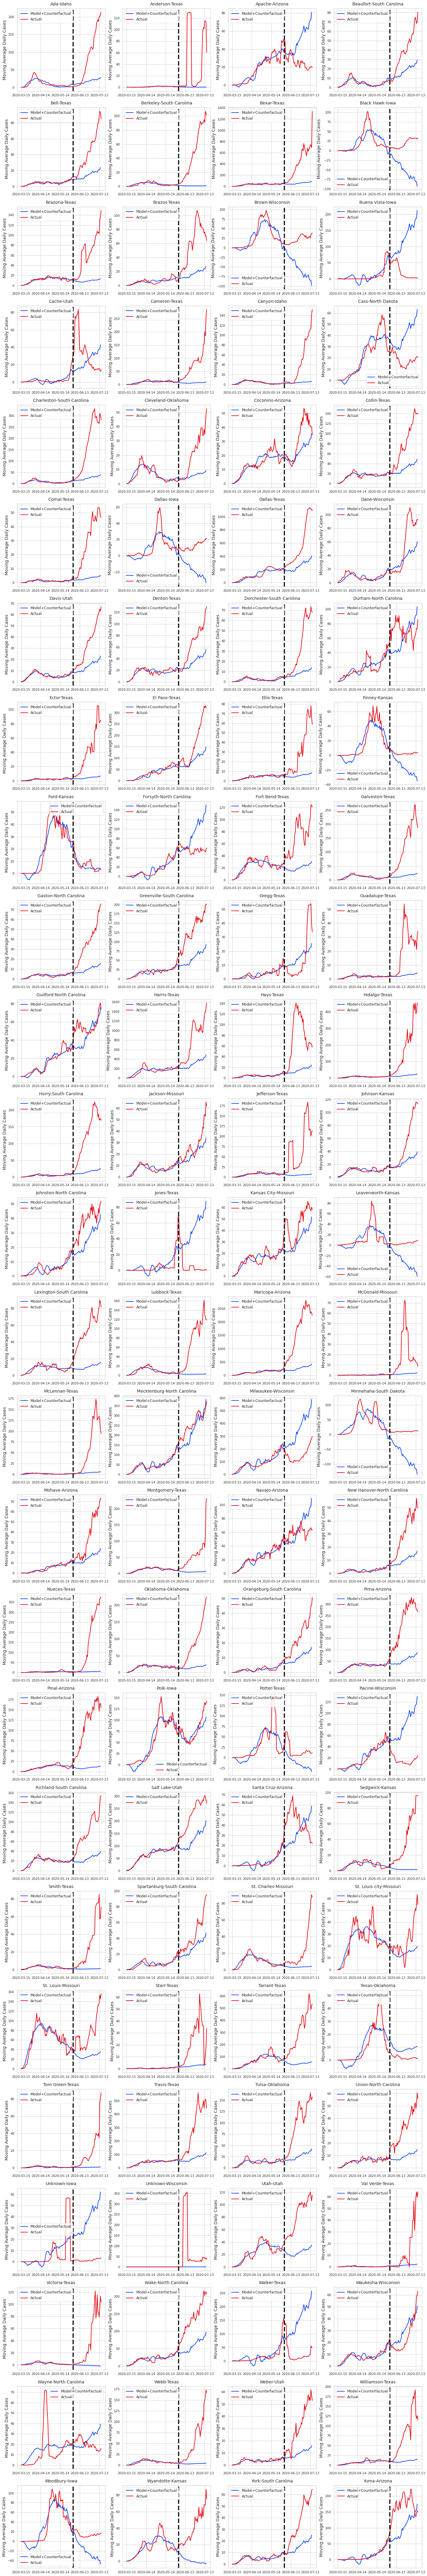

In [18]:
df = all_data_cases_daily.loc['2020-03-15':]
#df = df[df.columns[(df>100).any()]].copy()
plt.rcParams.update({'font.size': 10})
tick_spacing=30

#sizes = df.apply(pd.Series.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
high_thresh = df.shape[0]
low_thresh = high_thresh-45
targets = counties_recommended #counties_recommended #masks_mandated
otherStates = counties_mandated #masks_recommended
singVals=3
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

num_rows_to_plot = int(len(targets)/4)+1
plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*6.0)
#plt.rcParams['figure.figsize'] = (8, 6.0)

i=1
print("Counterfactual analysis of Mask recommended counties based on a donor pool of Mask mandated counties")
print("Intervention date: ", testDF.index[0])

for state in targets:
    #otherStates =  counties_recommended.copy()
    #otherStates.remove(state)
    all_rows = list.copy(otherStates)
    all_rows.append(state)
    rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
    rscModel.fit(trainDF)
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []
    
    predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
    ax = plt.subplot(num_rows_to_plot,4,i)
    #fig, ax = plt.subplots(1,1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(state,fontsize=14, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual'), plt.plot(df[state], label='Actual'), plt.legend(), 
    plt.ylabel('Moving Average Daily Cases'),
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend()
    #plt.savefig("../figures/"+state+".png")
    i=i+1
plt.show()


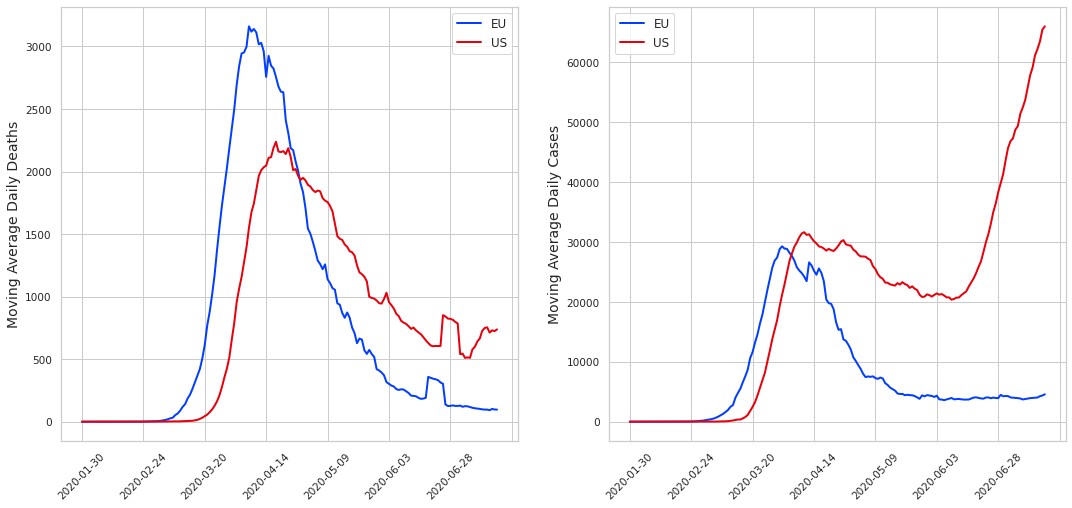

In [21]:
plt.rcParams['figure.figsize'] = (18, 8)

group_a = eu_countries
group_b = ['US']

group_a_label = "EU"
group_b_label = "US"

#group_a = masks_mandated
#group_b = masks_recommended

#group_a_label = 'Masks Mandated Everywhere'
#group_b_label = 'Masks Not Mandated Anywhere'

plt.subplot(1,2,1)
all_data_daily[group_a].sum(axis=1).plot(label=group_a_label), all_data_daily[group_b].sum(axis=1).plot(label=group_b_label), plt.legend(), plt.xticks(rotation=45), 
plt.ylabel('Moving Average Daily Deaths')
plt.subplot(1,2,2)
all_data_cases_daily[group_a].sum(axis=1).plot(label=group_a_label), all_data_cases_daily[group_b].sum(axis=1).plot(label=group_b_label), plt.legend(),
plt.xticks(rotation=45), plt.ylabel('Moving Average Daily Cases')
plt.show()

((array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
  <a list of 10 Text major ticklabel objects>),
 Text(0, 0.5, 'Moving Average Daily Cases'),
 Text(0.5, 1.0, 'Cases'))

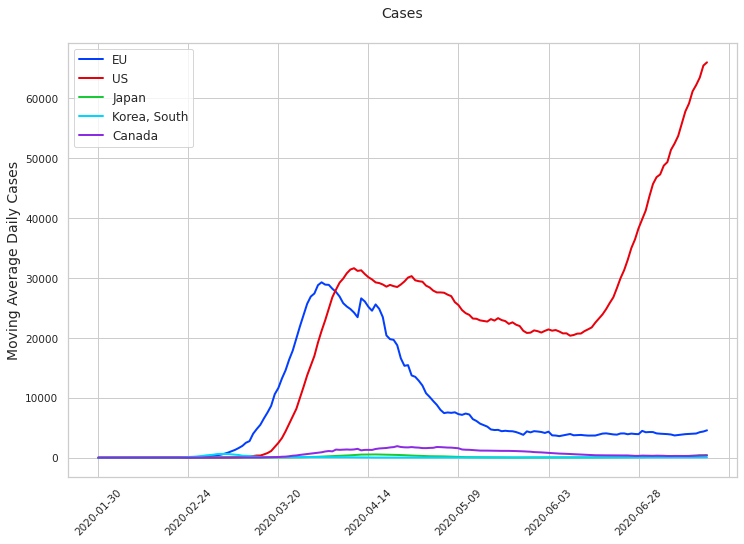

In [22]:
plt.rcParams['figure.figsize'] = (12, 8)
dfplot = all_data_cases_daily

dfplot[group_a].sum(axis=1).plot(label=group_a_label), dfplot['US'].plot(label=group_b_label), 
dfplot['Japan'].plot(), dfplot['Korea, South'].plot(), dfplot['Canada'].plot(), plt.legend(),
plt.xticks(rotation=45), plt.ylabel('Moving Average Daily Cases'), plt.title('Cases')

#dfplot = all_data_cases_daily

#dfplot[group_a].sum(axis=1).plot(label=group_a_label, secondary_y=True), dfplot['US'].plot(label=group_b_label, secondary_y=True), 
#dfplot['Japan'].plot(secondary_y=True), dfplot['Korea, South'].plot( secondary_y=True), dfplot['Canada'].plot(secondary_y=True), plt.legend(),
#plt.xticks(rotation=45), plt.ylabel('Moving Average Daily Cases'), plt.title('Cases')
#plt.show()

### Population adjusted counterfactual analysis

In [23]:
df = all_cases_data_pop[uscounties_cases_pop_adjusted.columns].loc['2020-03-08':]
#df = all_cases_data_pop_daily[uscounties_cases_pop_adjusted.columns].loc['2020-03-08':]

counties_mandated = []
for state in ['New York', 'Massachusetts', 'Connecticut']:
    counties_mandated = counties_mandated+list(uscounties.loc[uscounties.state == state].county_state.unique())

counties_recommended = []
for state in ['Louisiana']:
    counties_recommended = counties_recommended + list(uscounties.loc[uscounties.state == state].county_state.unique())

df1 = df[df.columns[(df>10).any()]].copy()

counties_mandated = list(df1.columns[df1.columns.isin(counties_mandated)])
df1 = df[df.columns[(df>10).any()]].copy()

counties_recommended = list(df1.columns[df1.columns.isin(counties_recommended)])

### California mask counterfactual analysis

In [197]:
from datetime import datetime
start_day = '2020-03-08'
df = all_cases_data_pop[uscounties_cases_pop_adjusted.columns].loc[start_day:]
#df = all_cases_data_pop_daily[uscounties_cases_pop_adjusted.columns].loc[start_day:]

start_dt = datetime.strptime(start_day, "%Y-%m-%d")
print(start_dt)

#skip counties with incomplete no community mobility data
ca_counties = list(uscounties.loc[uscounties.state == 'California'].county_state.unique())
ca_counties = list(set(ca_counties) - set(['Unknown-California']))

#Counties with a mandate by May 9, 2020
#Orange had one until June 11 so it's included
import numpy as np
cmd = [['Alameda-California','2020-04-22'], ['Contra Costa-California','2020-04-22'],
       ['Del Norte-California', '2020-04-02'], ['Humboldt-California', '2020-04-24'],
       ['Imperial-California', '2020-04-09'], ['Inyo-California', '2020-05-08'],
       ['Los Angeles-California', '2020-04-10'], ['Marin-California', '2020-04-22'], 
       ['Mendocino-California', '2020-05-01'], ['Mono-California', '2020-04-13'], 
       ['Monterey-California', '2020-04-30'], ['Napa-California', '2020-05-07'], 
       ['Orange-California', '2020-04-24'], ['Plumas-California', '2020-05-09'], 
       ['Riverside-California', '2020-04-06'], ['San Benito-California', '2020-04-27'], 
       ['San Bernardino-California', '2020-04-08'], ['San Diego-California', '2020-05-01'],
       ['San Francisco-California', '2020-04-22'], ['San Mateo-California', '2020-04-22'], 
       ['Santa Cruz-California', '2020-04-24'], ['Sierra-California', '2020-05-01'],
       ['Sonoma-California', '2020-04-17'], ['Yolo-California', '2020-04-24'], 
       ['Yuba-California', '2020-05-04']]
       
counties_mandated_dts = np.array(cmd)

counties_mandated = counties_mandated_dts[:,0]

counties_recommended = list(set(ca_counties) - set(counties_mandated))

df1 = df[df.columns[(df>10).any()]].copy()

counties_mandated = list(df1.columns[df1.columns.isin(counties_mandated)])
df1 = df[df.columns[(df>10).any()]].copy()

counties_recommended = list(df1.columns[df1.columns.isin(counties_recommended)])

print(len(counties_mandated), len(counties_recommended))

2020-03-08 00:00:00
25 32


102
Counterfactual analysis of CA Mask mandated counties based on a donor pool of Mask recommended counties
Intervention date specific to each county's order date (April 2-May 9)


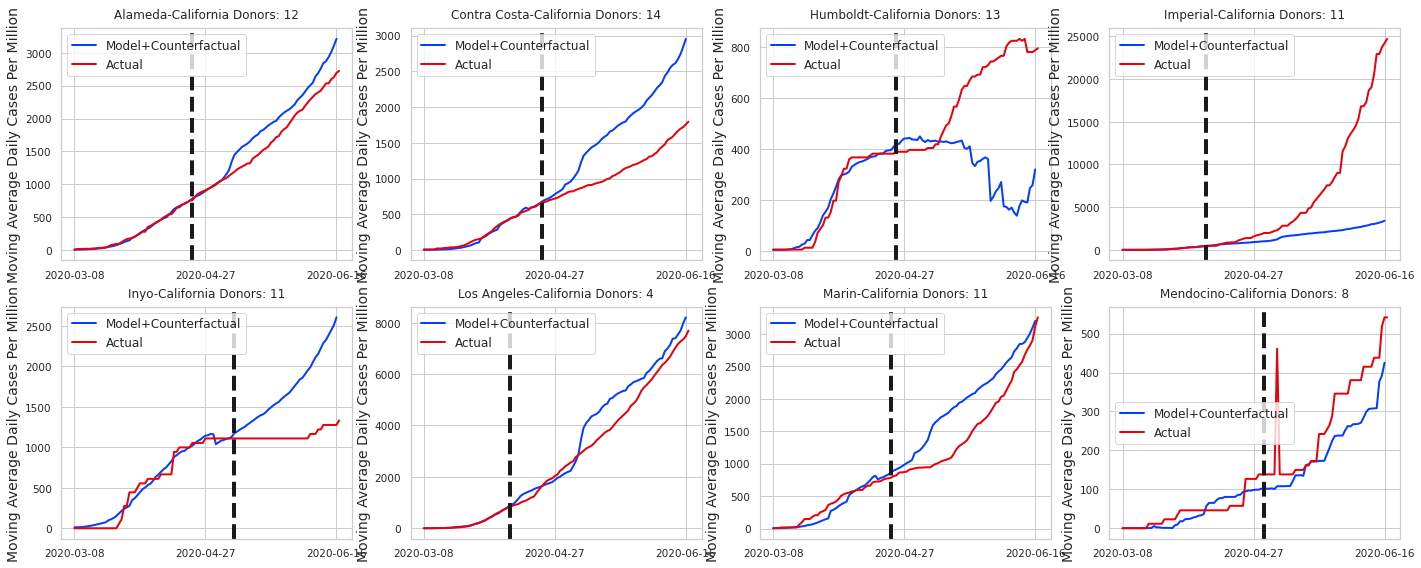

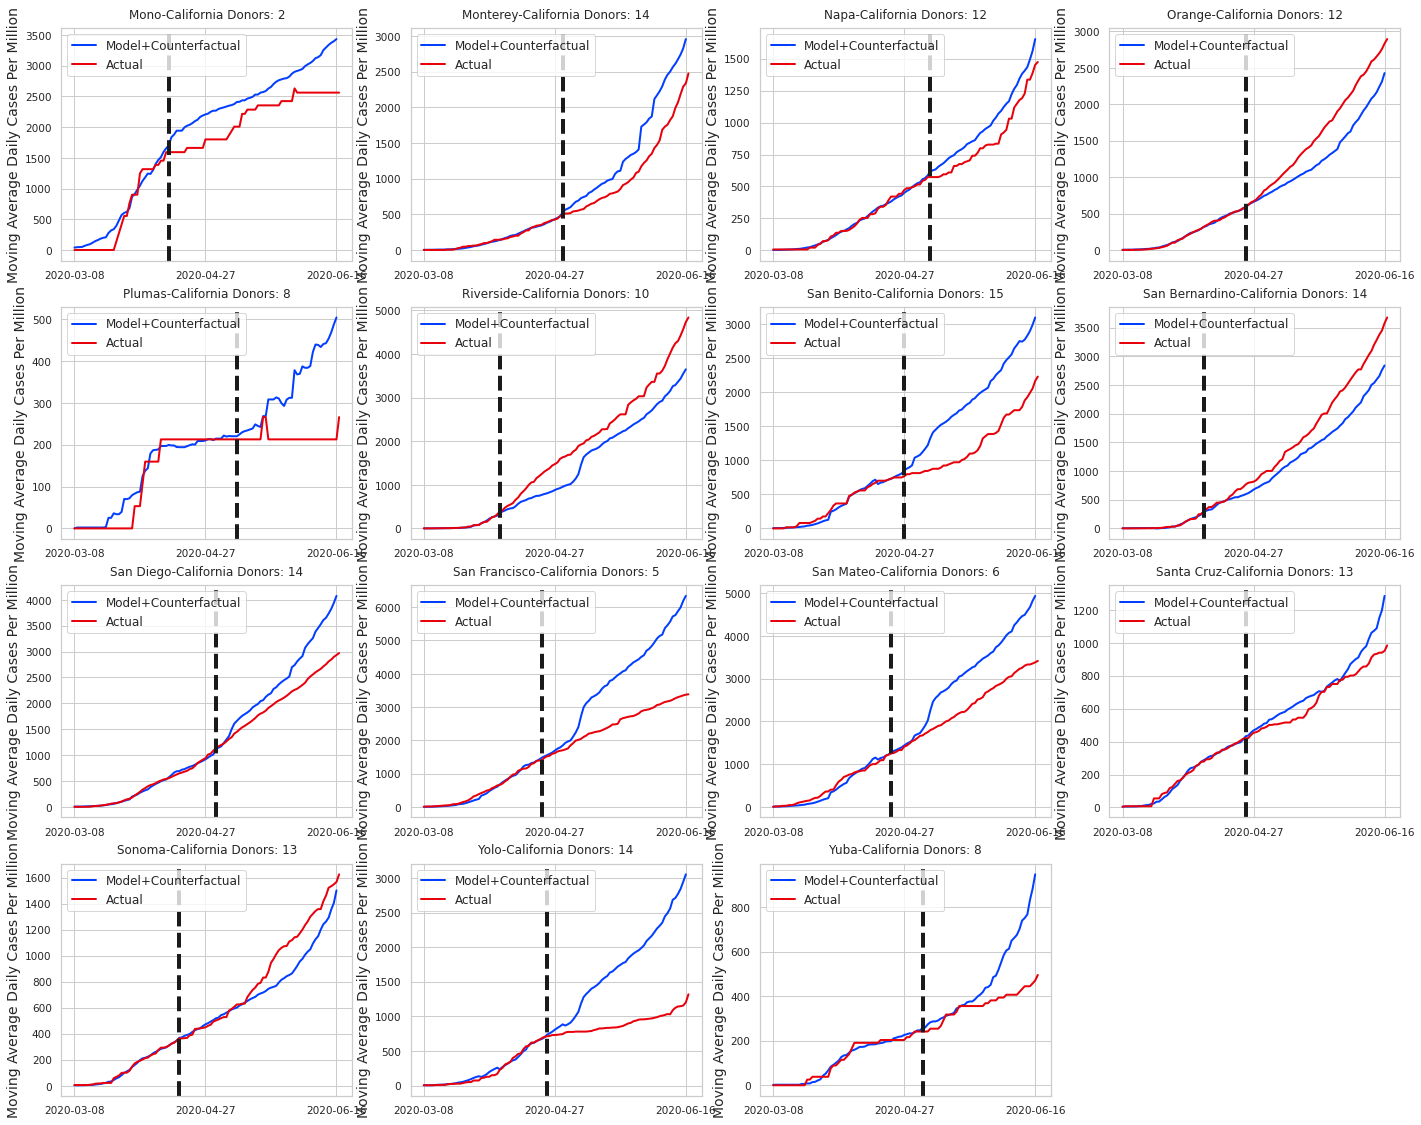

In [217]:

#df = df[df.columns[(df>100).any()]].copy()
plt.rcParams.update({'font.size': 10})
tick_spacing=50

#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
targets = counties_mandated.copy()
donors = counties_recommended.copy()
singVals=2

num_rows_to_plot = int(len(targets)/4)+1
plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
#plt.rcParams['figure.figsize'] = (8, 6.0)

#California statewide mask mandate on June 18 so end the comparison at that point...
end_dt = datetime.strptime("2020-06-18", "%Y-%m-%d")
    
high_thresh = (end_dt - start_dt).days
print(high_thresh)

i=1
print("Counterfactual analysis of CA Mask mandated counties based on a donor pool of Mask recommended counties")
print("Intervention date specific to each county's order date (April 2-May 9)")
for state in targets:    
    #lookup treatment date
    filter = np.asarray(state)
    treatment_day = counties_mandated_dts[np.in1d(counties_mandated_dts[:,0], filter)][0][1]
    treatment_dt = datetime.strptime(treatment_day, "%Y-%m-%d")
    
    low_thresh = (treatment_dt - start_dt).days
    
    trainDF=df.iloc[:low_thresh,:]
    testDF=df.iloc[low_thresh+1:high_thresh,:]

    #otherStates =  donors.copy()
    otherStates = df.columns[(df.iloc[low_thresh] < df[state].iloc[low_thresh]+.5*df[state].iloc[low_thresh])&(df.iloc[low_thresh] > df[state].iloc[low_thresh]-0.5*df[state].iloc[low_thresh])]
    otherStates = list(otherStates[otherStates.isin(donors)])
    #print(state, "\n", len(otherStates))
    if state in otherStates:
        otherStates.remove(state)
    all_rows = list.copy(otherStates)
    all_rows.append(state)
    rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
    rscModel.fit(trainDF)
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []
    
    predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
    fit_error = mse(model_fit, df[state][:low_thresh])
    prediction_error = mse(predictions, df[state][low_thresh+1:high_thresh])
    #print(state, fit_error, prediction_error)
    if(fit_error > 20):
        #print(state, fit_error)
        continue
    if((trainDF[state]>10).any()):
        #print(state)
        w=2
    else:
        continue
    ax = plt.subplot(num_rows_to_plot,4,i)
    #fig, ax = plt.subplots(1,1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(state+" Donors: "+str(len(otherStates)),fontsize=12, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual'), plt.plot(df[state][0:high_thresh], label='Actual'), plt.legend(), 
    plt.ylabel('Moving Average Daily Cases Per Million'),
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend()
    #plt.savefig("../figures/"+state+".png")
    i=i+1
    if(i==9):
        plt.show()
plt.show()

In [221]:
print(google_ca_mobility.loc['Alameda-California'].to_list())

[-2.0, 0.0, -1.0, -1.0, -1.0, -6.0, -25.0, -25.0, -6.0, -44.0, -46.0, -45.0, -49.0, -58.0, -57.0, -49.0, -51.0, -49.0, -49.0, -52.0, -61.0, -58.0, -48.0, -48.0, -48.0, -49.0, -51.0, -62.0, -65.0, -53.0, -50.0, -53.0, -53.0, -53.0, -59.0, -67.0, -51.0, -50.0, -54.0, -64.0, -65.0, -69.0, -68.0, -63.0, -63.0, -63.0, -62.0, -64.0, -67.0, -66.0, -61.0, -61.0, -60.0, -57.0, -57.0, -62.0, -60.0, -54.0, -54.0, -55.0, -55.0, -56.0, -58.0, -58.0, -56.0, -55.0, -54.0, -54.0, -55.0, -58.0, -59.0, -52.0, -51.0, -50.0, -49.0, -50.0, -55.0, -53.0, -52.0, -48.0, -48.0, -48.0, -50.0, -56.0, -55.0, -53.0, -53.0, -51.0, -50.0, -52.0, -55.0, -53.0, -47.0, -47.0, -47.0, -47.0, -49.0, -52.0, -52.0, -46.0, -46.0, -46.0, -44.0]
date                        2020-03-08  2020-03-09  2020-03-10  2020-03-11  \
county                                                                       
Alameda-California                -2.0         0.0        -1.0        -1.0   
Amador-California                 21.0         4.0  

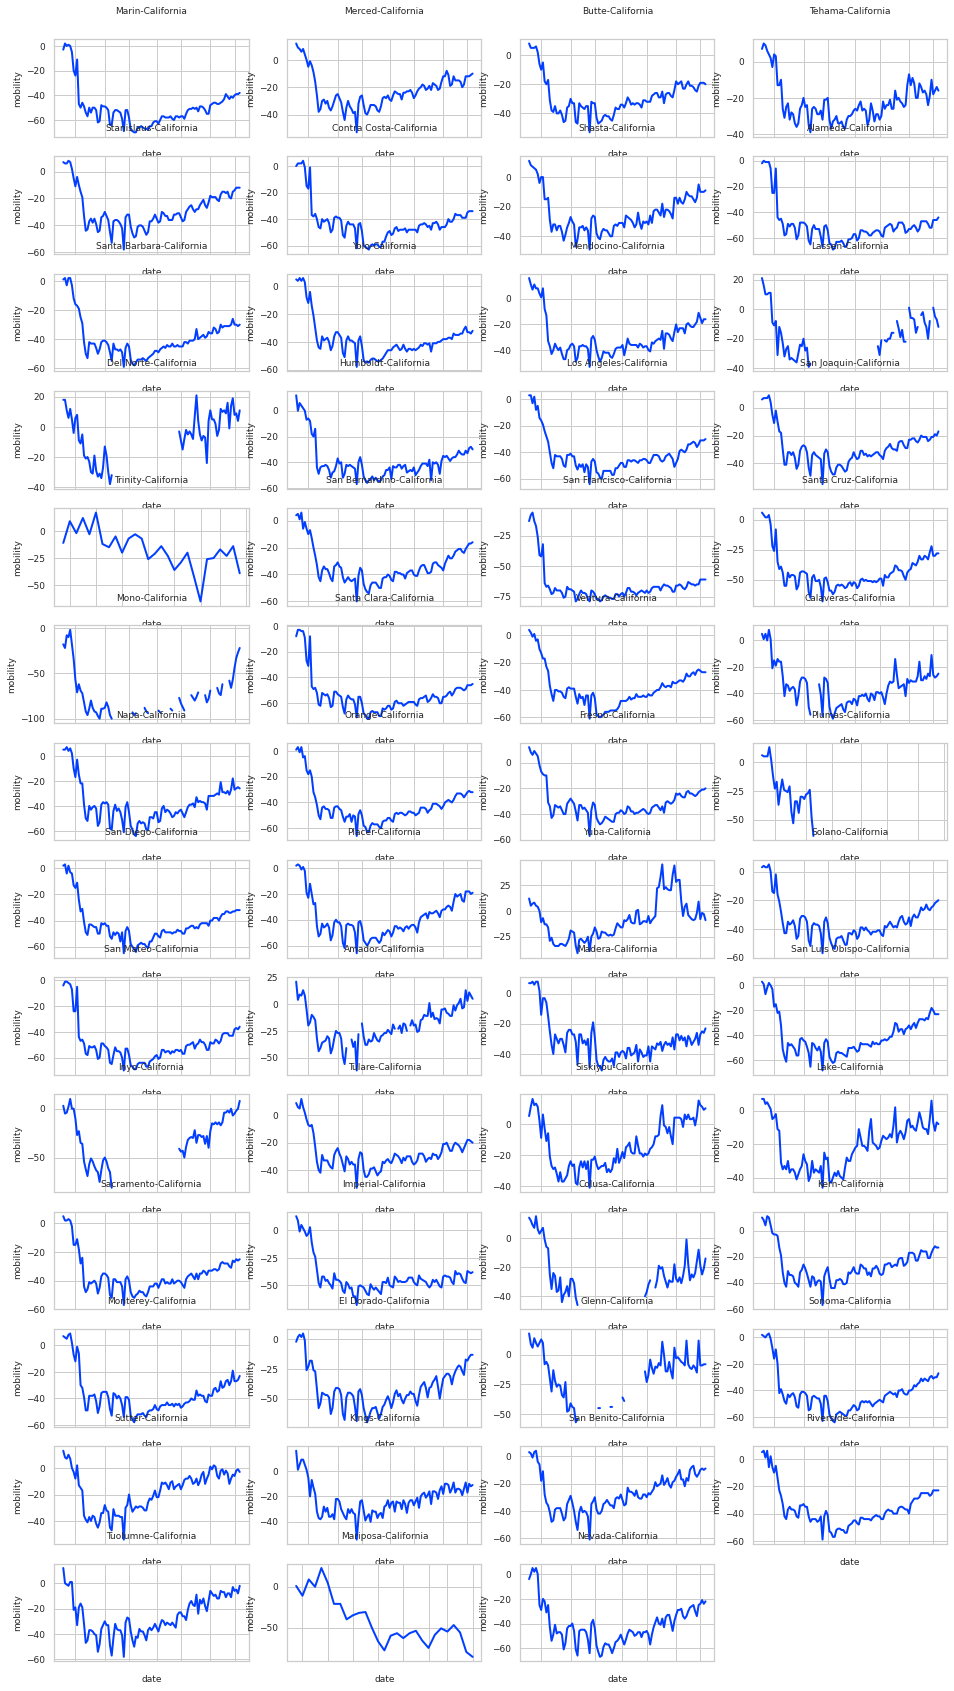

In [216]:
plt.rcParams['figure.figsize'] = (16,32)

FONTSIZE = 9

cc = list(set(ca_counties)-set(['Alpine-California','Sierra-California']))
#fig, ax = plt.subplots(4)
for i in range(len(cc)):
    ax = plt.subplot(15,4, i+1)
    #plt.setp( ax.get_xticklabels(), visible=False)

    #plt.xticks(rotation=45)

    google_ca_mobility.loc[cc[i]].plot(ax=ax )
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

    #ax.tick_params(axis='x', rotation=45)
    plt.xlabel('date',fontsize = FONTSIZE), plt.ylabel('mobility',fontsize = FONTSIZE), 
    plt.xticks(fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE), plt.title(cc[i], fontsize = FONTSIZE)


    
#plt.savefig('../Figures/COVID/google_ca_mobility.pdf', bbox_inches='tight')

plt.show()

In [258]:
def compute_corr(x,y):
#    print(x,y)
#    print(stats.pearsonr(x, y)[0])
    return stats.pearsonr(x, y)[0]

Counterfactual analysis of CA Mask mandated counties based on a donor pool of Mask recommended counties
Intervention date specific to each county's order date (April 2-May 9)
Lowered threshold to  0.88  for  San Francisco-California


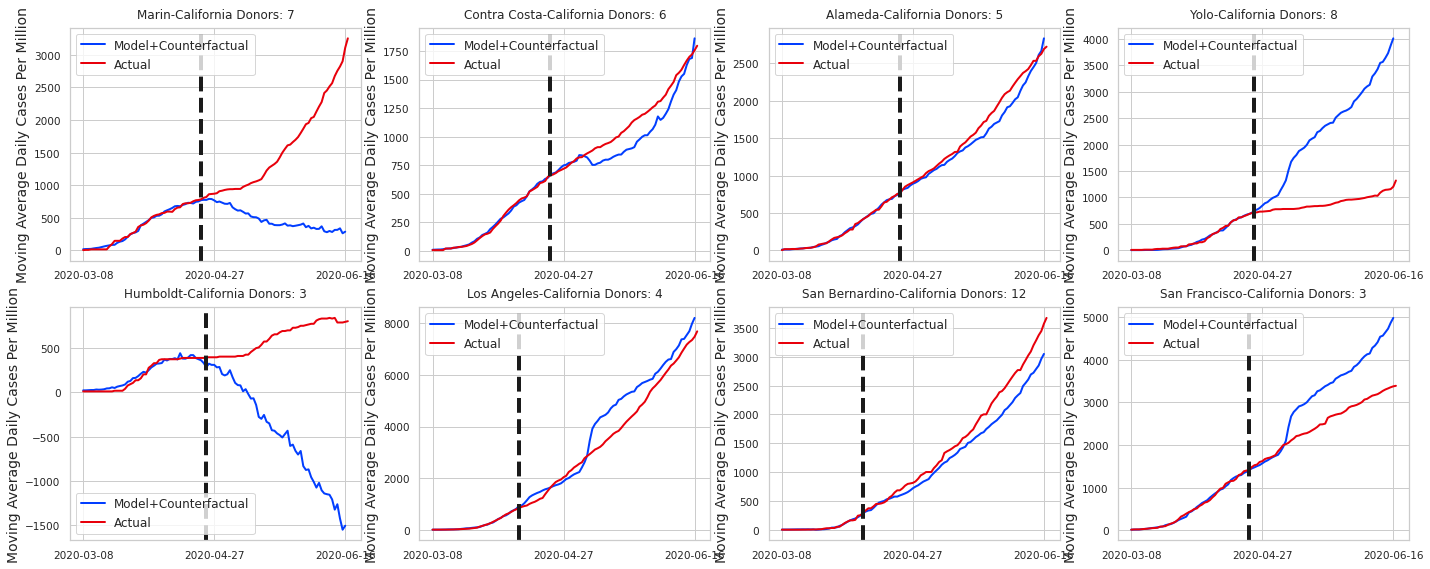

Insufficient donor pool for  Yuba-California
Lowered threshold to  0.88  for  Imperial-California
Lowered threshold to  0.88  for  San Benito-California


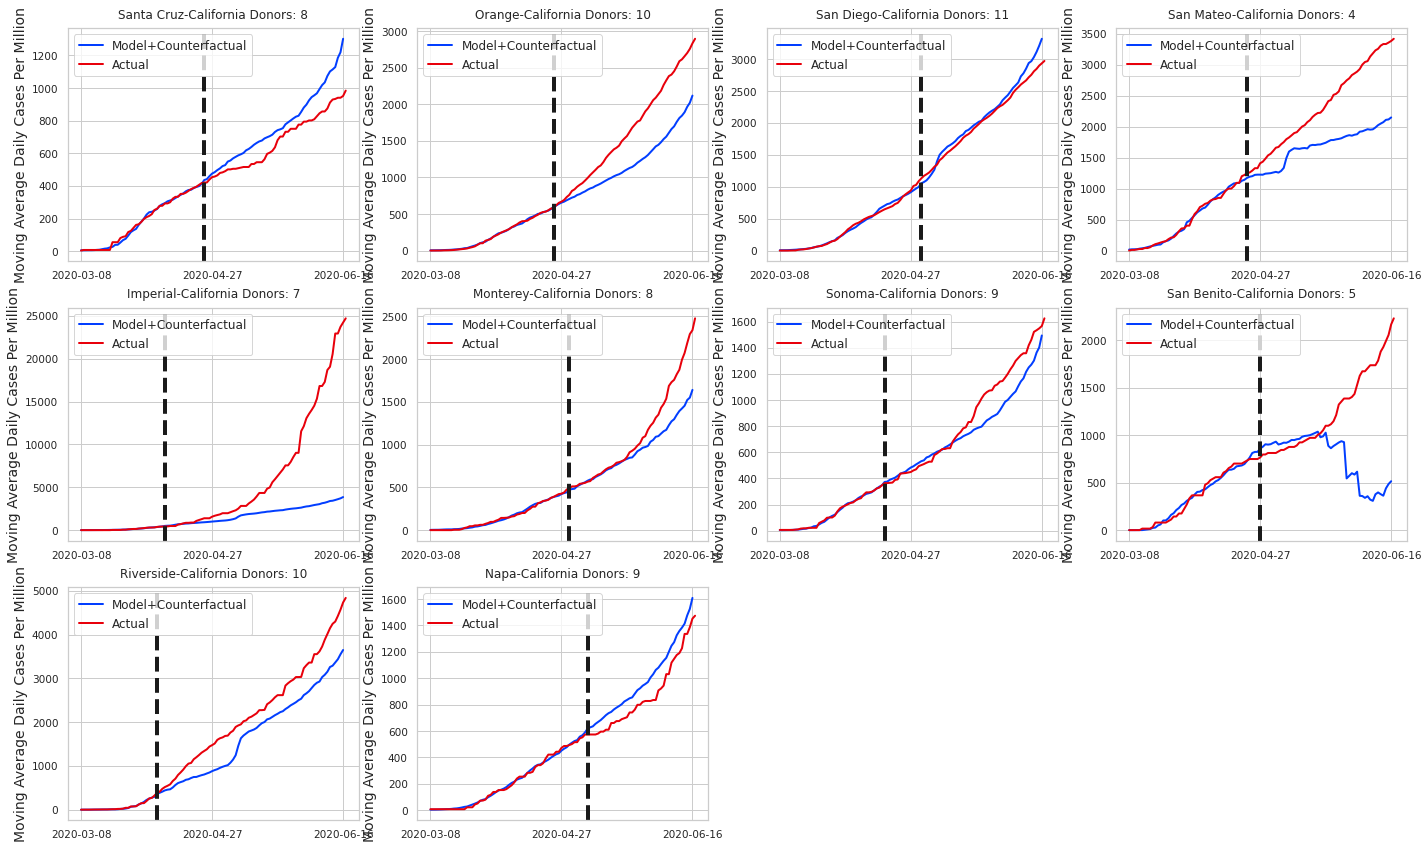

In [268]:
import pandas as pd
import numpy as np
import scipy.stats as stats

hasmobility = google_ca_mobility.dropna()
#print(hasmobility.loc['Alameda-California'].to_list())

cc = set(ca_counties)-set(['Alpine-California','Sierra-California','Lassen-California','Del Norte-California','Trinity-California','Mono-California',
                               'Calaveras-California', 'Plumas-California', 'Amador-California', 'Inyo-California','Colusa-California','Glenn-California',
                               'Mariposa-California'])

correlation_thresholds = [0.93, 0.88, 0.83]
        
        
#df = df[df.columns[(df>100).any()]].copy()
plt.rcParams.update({'font.size': 10})
tick_spacing=50

#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
targets = list(set(counties_mandated).intersection(cc))
donors = list(set(counties_recommended).intersection(cc))
singVals=2

#print(donors)
donor_mobility = hasmobility[hasmobility.index.isin(donors)]
#print(donor_mobility)

num_rows_to_plot = int(len(targets)/4)+1
plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)

#California statewide mask mandate on June 18 so end the comparison at that point...
end_dt = datetime.strptime("2020-06-18", "%Y-%m-%d")
    
high_thresh = (end_dt - start_dt).days
#print(high_thresh)

i=1
print("Counterfactual analysis of CA Mask mandated counties based on a donor pool of Mask recommended counties")
print("Intervention date specific to each county's order date (April 2-May 9)")
for state in targets:    
    #lookup treatment date
    filter = np.asarray(state)
    treatment_day = counties_mandated_dts[np.in1d(counties_mandated_dts[:,0], filter)][0][1]
    treatment_dt = datetime.strptime(treatment_day, "%Y-%m-%d")
    
    low_thresh = (treatment_dt - start_dt).days
    
    trainDF=df.iloc[:low_thresh,:]
    testDF=df.iloc[low_thresh+1:high_thresh,:]

    #otherStates =  donors.copy()
    otherStates = df.columns[(df.iloc[low_thresh] < df[state].iloc[low_thresh]+.5*df[state].iloc[low_thresh])&(df.iloc[low_thresh] > df[state].iloc[low_thresh]-0.5*df[state].iloc[low_thresh])]
    otherStates = list(otherStates[otherStates.isin(donors)])
    if state in otherStates:
        otherStates.remove(state)

    matches = []
    for correlation_threshold in correlation_thresholds:
        #high_corr = donor_mobility.columns[(stats.pearsonr(hasmobility.loc[state], donor_mobility))>=correlation_treshold]
        high_corr = donor_mobility[donor_mobility.apply(lambda r : compute_corr(hasmobility.loc[state], r), axis=1)>=correlation_threshold]
        #print(state)
        #print(high_corr.index.values)
        #print(otherStates)
        matches = list(set(otherStates).intersection(high_corr.index.values))
        #print(matches)
        if (len(matches)>=2):
            #print(len(matches), " states for ", correlation_treshold, " for "+state)
            if (correlation_threshold < correlation_thresholds[0]):
                print("Lowered threshold to ", correlation_threshold, " for ", state)
            break
        #print("Only ", len(matches), " states for ", correlation_treshold, " for "+state)
    if (not matches):
        print("Insufficient donor pool for ", state)
        continue
    otherStates = matches
        
    #TODO push down into loop to filter
    #        r = stats.pearsonr(hasmobility.loc[a].to_list(), hasmobility.loc[b].to_list())

    all_rows = list.copy(otherStates)
    all_rows.append(state)
    rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
    rscModel.fit(trainDF)
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []
    
    predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
    fit_error = mse(model_fit, df[state][:low_thresh])
    prediction_error = mse(predictions, df[state][low_thresh+1:high_thresh])
    #print(state, fit_error, prediction_error)
    if(fit_error > 20):
        #print(state, fit_error)
        continue
    if((trainDF[state]>10).any()):
        #print(state)
        w=2
    else:
        continue
    ax = plt.subplot(num_rows_to_plot,4,i)
    #fig, ax = plt.subplots(1,1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(state+" Donors: "+str(len(otherStates)),fontsize=12, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual'), plt.plot(df[state][0:high_thresh], label='Actual'), plt.legend(), 
    plt.ylabel('Moving Average Daily Cases Per Million'),
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend()
    #plt.savefig("../figures/"+state+".png")
    i=i+1
    if(i==9):
        plt.show()
plt.show()


Counterfactual analysis of CA Mask mandated counties based on a donor pool of Mask recommended counties
Intervention date specific to each county's order date (April 2-May 9)


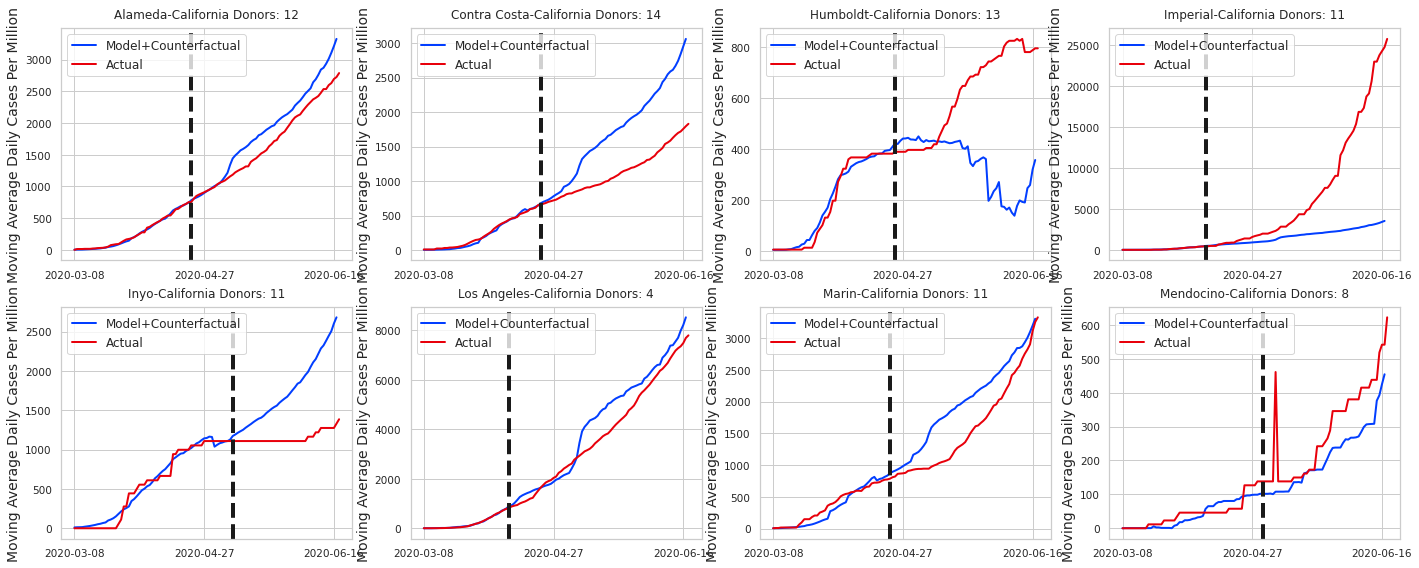

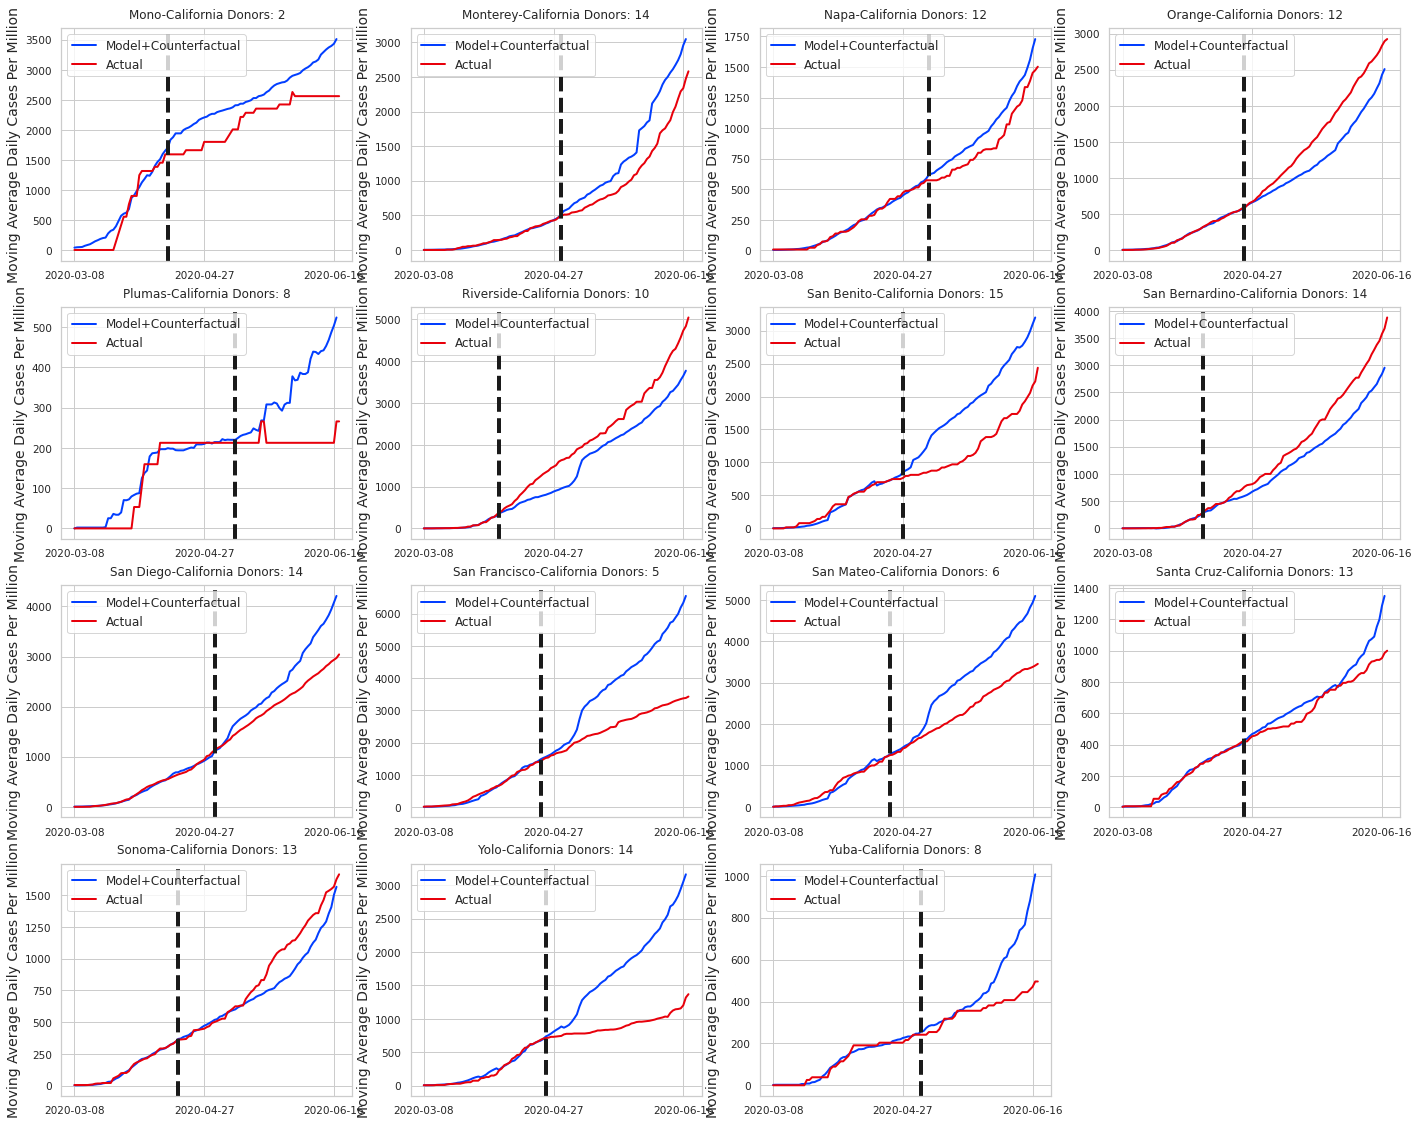

In [79]:

#df = df[df.columns[(df>100).any()]].copy()
plt.rcParams.update({'font.size': 10})
tick_spacing=50

#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
targets = counties_mandated.copy()
donors = counties_recommended.copy()
singVals=2

num_rows_to_plot = int(len(targets)/4)+1
plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
#plt.rcParams['figure.figsize'] = (8, 6.0)

#California statewide mask mandate on June 18 so end the comparison at that point...
end_dt = datetime.strptime("2020-06-18", "%Y-%m-%d")
    
high_thresh = (end_dt - start_dt).days
print(high_thresh)

i=1
print("Counterfactual analysis of CA Mask mandated counties based on a donor pool of Mask recommended counties")
print("Intervention date specific to each county's order date (April 2-May 9)")
for state in targets:    
    #lookup treatment date
    filter = np.asarray(state)
    treatment_day = counties_mandated_dts[np.in1d(counties_mandated_dts[:,0], filter)][0][1]
    treatment_dt = datetime.strptime(treatment_day, "%Y-%m-%d")
    
    low_thresh = (treatment_dt - start_dt).days
    
    trainDF=df.iloc[:low_thresh,:]
    testDF=df.iloc[low_thresh+1:high_thresh,:]

    #otherStates =  donors.copy()
    otherStates = df.columns[(df.iloc[low_thresh] < df[state].iloc[low_thresh]+.5*df[state].iloc[low_thresh])&(df.iloc[low_thresh] > df[state].iloc[low_thresh]-0.5*df[state].iloc[low_thresh])]
    otherStates = list(otherStates[otherStates.isin(donors)])
    #print(state, "\n", len(otherStates))
    if state in otherStates:
        otherStates.remove(state)
    all_rows = list.copy(otherStates)
    all_rows.append(state)
    rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
    rscModel.fit(trainDF)
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []
    
    predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
    fit_error = mse(model_fit, df[state][:low_thresh])
    prediction_error = mse(predictions, df[state][low_thresh+1:high_thresh])
    #print(state, fit_error, prediction_error)
    if(fit_error > 20):
        #print(state, fit_error)
        continue
    if((trainDF[state]>10).any()):
        #print(state)
        w=2
    else:
        continue
    ax = plt.subplot(num_rows_to_plot,4,i)
    #fig, ax = plt.subplots(1,1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(state+" Donors: "+str(len(otherStates)),fontsize=12, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual'), plt.plot(df[state][0:high_thresh], label='Actual'), plt.legend(), 
    plt.ylabel('Moving Average Daily Cases Per Million'),
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend()
    #plt.savefig("../figures/"+state+".png")
    i=i+1
    if(i==9):
        plt.show()
plt.show()


Counterfactual analysis of CA Mask recommended counties based on a donor pool of Mask mandated counties
Intervention date:  2020-05-09


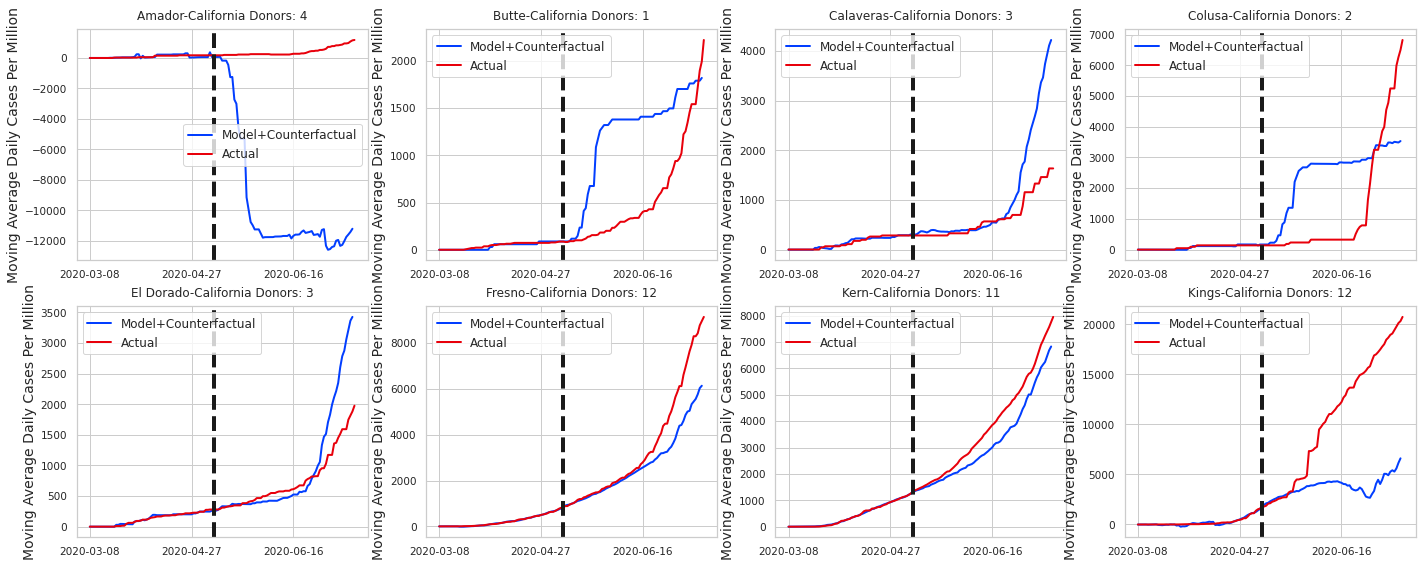

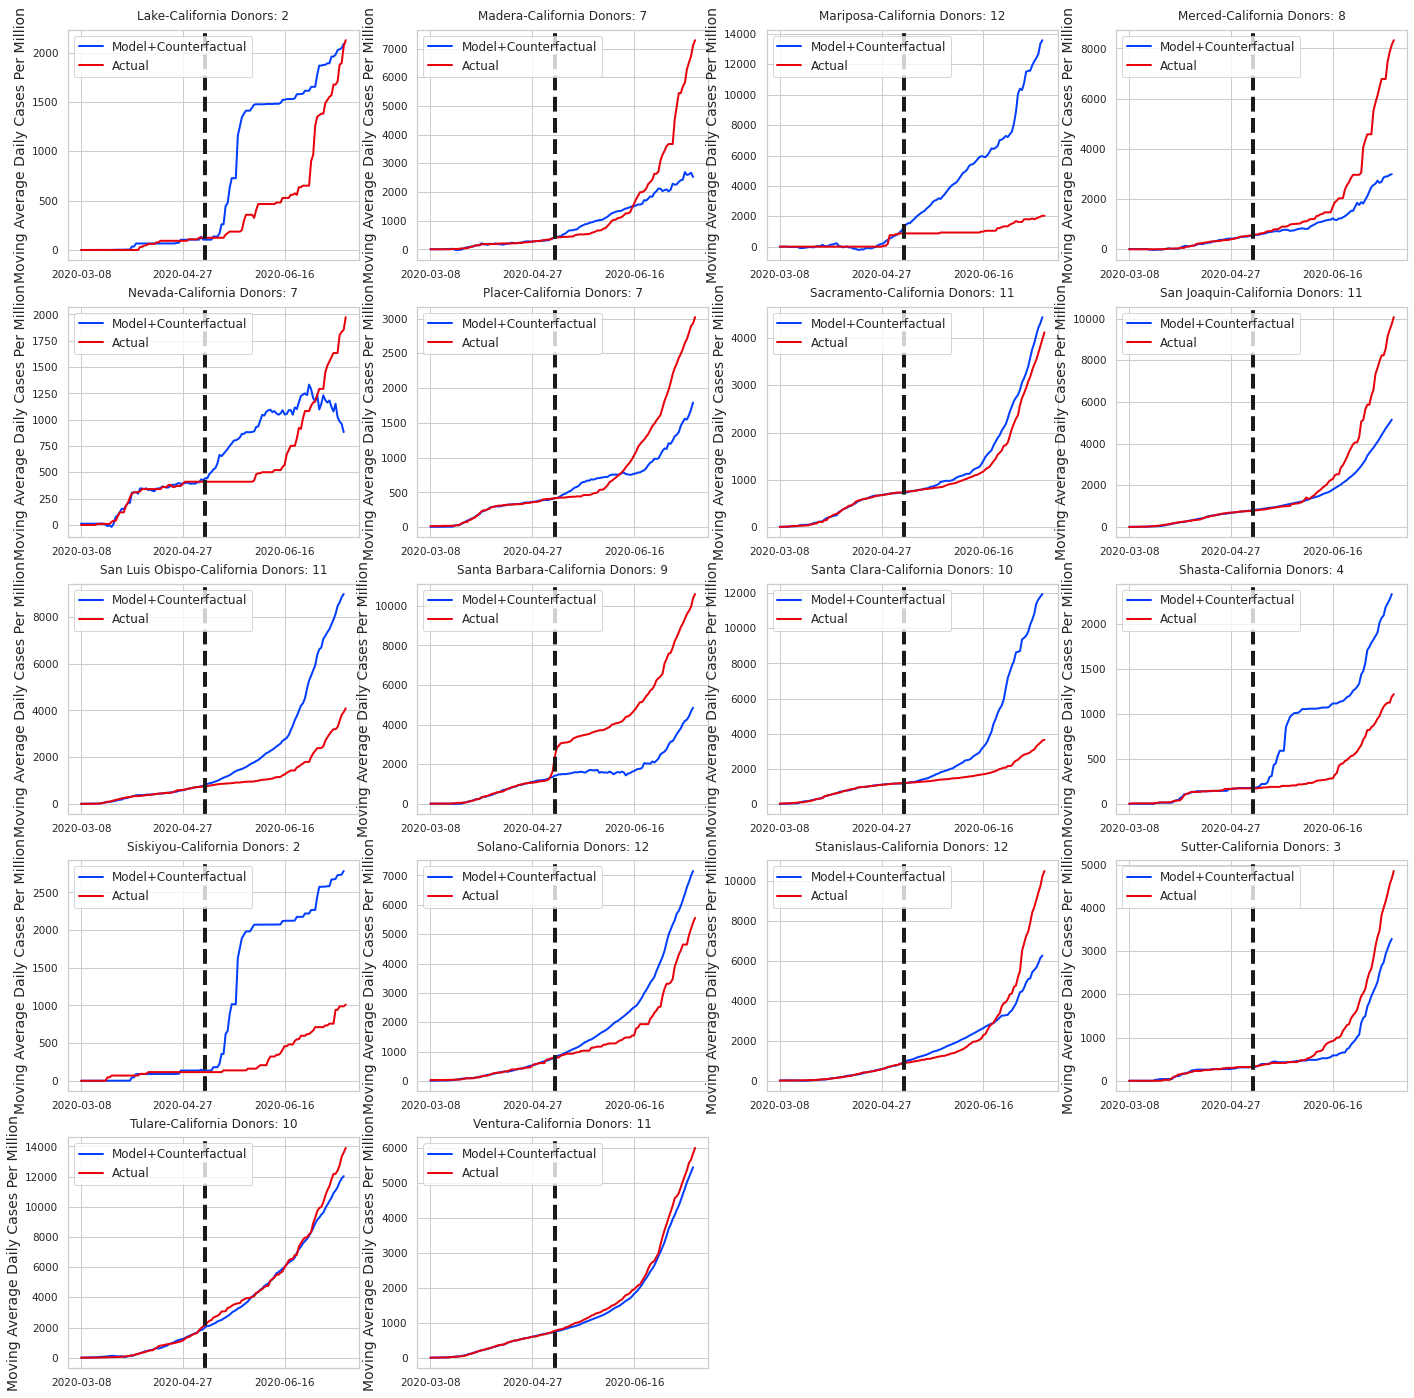

In [44]:

#df = df[df.columns[(df>100).any()]].copy()
plt.rcParams.update({'font.size': 10})
tick_spacing=50

#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
high_thresh = df.shape[0]
low_thresh = high_thresh-71
#targets = paired_list.copy() #counties_recommended #masks_mandated
targets = counties_recommended.copy()
donors = counties_mandated.copy() #masks_recommended
singVals=4
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

num_rows_to_plot = int(len(targets)/4)+1
plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
#plt.rcParams['figure.figsize'] = (8, 6.0)

i=1
print("Counterfactual analysis of CA Mask recommended counties based on a donor pool of Mask mandated counties")
print("Intervention date: ", testDF.index[0])
for state in targets:
    #otherStates =  donors.copy()
    otherStates = df.columns[(df.iloc[low_thresh] < df[state].iloc[low_thresh]+.5*df[state].iloc[low_thresh])&(df.iloc[low_thresh] > df[state].iloc[low_thresh]-0.5*df[state].iloc[low_thresh])]
    otherStates = list(otherStates[otherStates.isin(donors)])
    #print(state, "\n", len(otherStates))
    if state in otherStates:
        otherStates.remove(state)
    all_rows = list.copy(otherStates)
    all_rows.append(state)
    rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
    rscModel.fit(trainDF)
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []
    
    predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
    fit_error = mse(model_fit, df[state][:low_thresh])
    prediction_error = mse(predictions, df[state][low_thresh+1:])
    #print(state, fit_error, prediction_error)
    if(fit_error > 20):
        #print(state, fit_error)
        continue
    if((trainDF[state]>10).any()):
        #print(state)
        w=2
    else:
        continue
    ax = plt.subplot(num_rows_to_plot,4,i)
    #fig, ax = plt.subplots(1,1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(state+" Donors: "+str(len(otherStates)),fontsize=12, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual'), plt.plot(df[state], label='Actual'), plt.legend(), 
    plt.ylabel('Moving Average Daily Cases Per Million'),
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend()
    #plt.savefig("../figures/"+state+".png")
    i=i+1
    if(i==9):
        plt.show()
plt.show()


Counterfactual analysis of CA Mask mandated counties based on a donor pool of Mask recommended counties
Intervention date:  2020-05-09


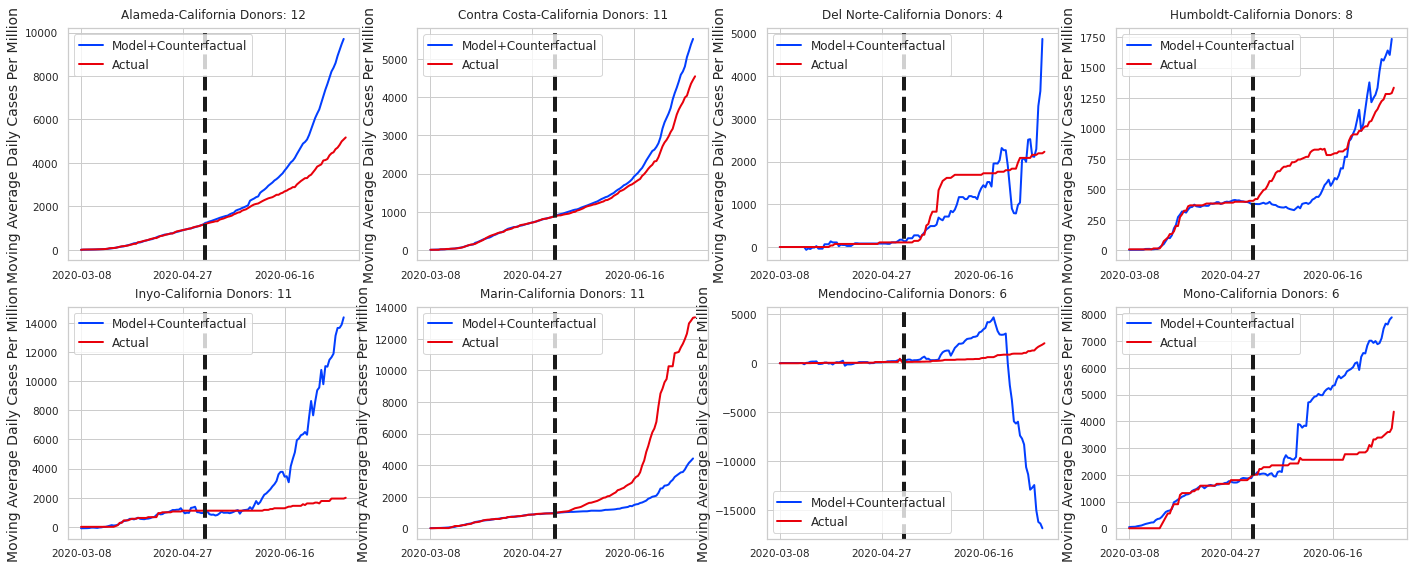

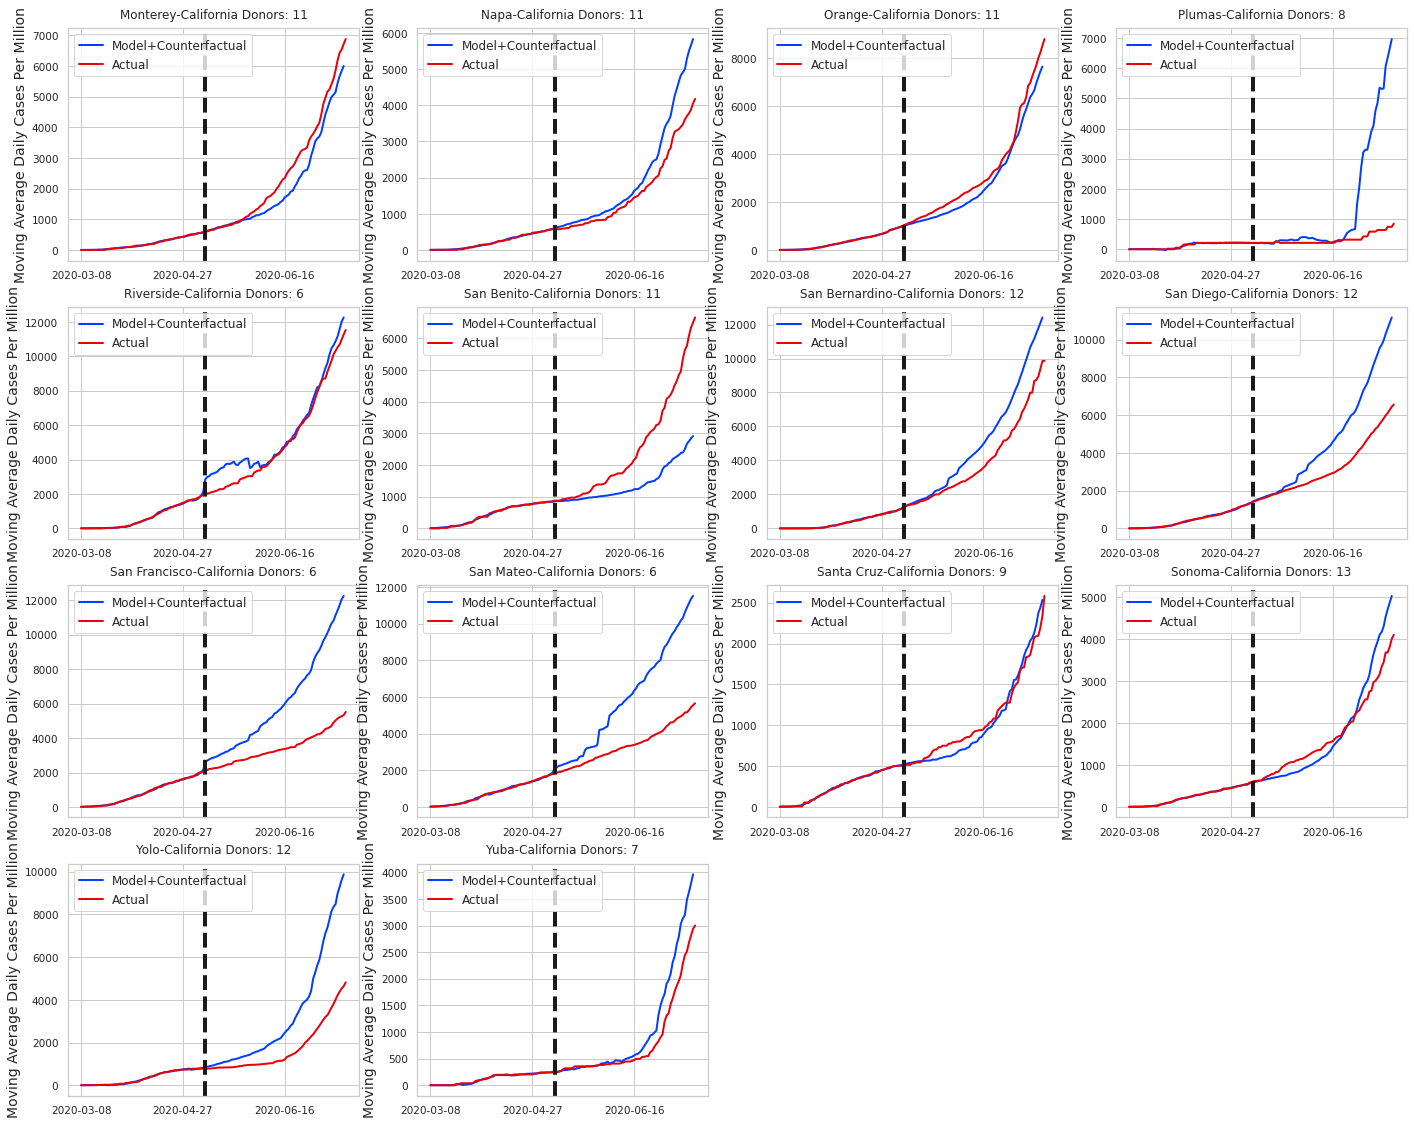

In [45]:

#df = df[df.columns[(df>100).any()]].copy()
plt.rcParams.update({'font.size': 10})
tick_spacing=50

#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
high_thresh = df.shape[0]
low_thresh = high_thresh-71
#targets = paired_list.copy() #counties_recommended #masks_mandated
targets = counties_mandated.copy()
donors = counties_recommended.copy() #masks_recommended
singVals=4
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

num_rows_to_plot = int(len(targets)/4)+1
plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
#plt.rcParams['figure.figsize'] = (8, 6.0)

i=1
print("Counterfactual analysis of CA Mask mandated counties based on a donor pool of Mask recommended counties")
print("Intervention date: ", testDF.index[0])
for state in targets:
    #otherStates =  donors.copy()
    otherStates = df.columns[(df.iloc[low_thresh] < df[state].iloc[low_thresh]+.5*df[state].iloc[low_thresh])&(df.iloc[low_thresh] > df[state].iloc[low_thresh]-0.5*df[state].iloc[low_thresh])]
    otherStates = list(otherStates[otherStates.isin(donors)])
    #print(state, "\n", len(otherStates))
    if state in otherStates:
        otherStates.remove(state)
    all_rows = list.copy(otherStates)
    all_rows.append(state)
    rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
    rscModel.fit(trainDF)
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []
    
    predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
    fit_error = mse(model_fit, df[state][:low_thresh])
    prediction_error = mse(predictions, df[state][low_thresh+1:])
    #print(state, fit_error, prediction_error)
    if(fit_error > 20):
        #print(state, fit_error)
        continue
    if((trainDF[state]>10).any()):
        #print(state)
        w=2
    else:
        continue
    ax = plt.subplot(num_rows_to_plot,4,i)
    #fig, ax = plt.subplots(1,1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(state+" Donors: "+str(len(otherStates)),fontsize=12, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual'), plt.plot(df[state], label='Actual'), plt.legend(), 
    plt.ylabel('Moving Average Daily Cases Per Million'),
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend()
    #plt.savefig("../figures/"+state+".png")
    i=i+1
    if(i==9):
        plt.show()
plt.show()


In [367]:
df = all_cases_data_pop_daily[uscounties_cases_pop_adjusted.columns].loc['2020-03-08':]
df_pop = all_cases_data_pop[uscounties_cases_pop_adjusted.columns].loc['2020-03-08':]

#df = all_cases_data_pop_daily[uscounties_cases_pop_adjusted.columns].loc['2020-03-08':]

counties_mandated = []
for state in ['New York', 'Massachusetts', 'New Jersey', 'Connecticut', 'New Hampshire', 'Vermont', 'Maine']:
    counties_mandated = counties_mandated+list(uscounties.loc[uscounties.state == state].county_state.unique())

counties_recommended = []
for state in ['Louisiana']:
    counties_recommended = counties_recommended + list(uscounties.loc[uscounties.state == state].county_state.unique())

df1 = df[df.columns[(df>10).any()]].copy()

counties_mandated = list(df1.columns[df1.columns.isin(counties_mandated)])
df1 = df[df.columns[(df>10).any()]].copy()

counties_recommended = list(df1.columns[df1.columns.isin(counties_recommended)])

In [31]:

#df = df[df.columns[(df>100).any()]].copy()
plt.rcParams.update({'font.size': 10})
tick_spacing=50

#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
high_thresh = df.shape[0]
low_thresh = high_thresh-52
targets = counties_recommended #counties_recommended #masks_mandated
donors = counties_mandated.copy() #masks_recommended
singVals=3
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (16, 6.0)

i=1
print("Counterfactual analysis of Mask recommended counties based on a donor pool of Mask mandated counties")
print("Intervention date: ", testDF.index[0])
for state in targets:
    df_pop =  donors.copy()
    ##df_pop doesn't resolve
    otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                  df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                                                                                     > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    otherStates = list(otherStates[otherStates.isin(donors)])
    #print(state, "\n", len(otherStates))
    if state in otherStates:
        otherStates.remove(state)
    all_rows = list.copy(otherStates)
    all_rows.append(state)
    rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
    rscModel.fit(trainDF)
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []
    
    predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
    fit_error = mse(model_fit, df[state][:low_thresh])
    prediction_error = mse(predictions, df[state][low_thresh+1:])
    #print(state, fit_error, prediction_error)
    if(len(otherStates)<10):
        continue
    if(fit_error > 20):
        #print(state, fit_error)
        continue
    if((trainDF[state]>10).any()):
        #print(state)
        w=2
    else:
        continue
    
    #ax = plt.subplot(num_rows_to_plot,2,2*i-1)
    ax = plt.subplot(1,2,1)
    #fig, ax = plt.subplots(1,1)
        
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(state+" Donors: "+str(len(otherStates))
                 + ", Cases on "+ df_pop.index[low_thresh]+ ": " + str(int(df_pop[state].iloc[low_thresh])) ,fontsize=12, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual'), plt.plot(df[state], label='Actual'), plt.legend(), 
    plt.ylabel('Moving Average Daily Cases Per Million'),
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend()
    
    new_state = otherStates[np.argmin(np.abs(df_pop[otherStates].iloc[low_thresh]-df_pop[state].iloc[low_thresh]))]
    #otherStates = df.columns[(df.iloc[low_thresh] < df[new_state].iloc[low_thresh]+
    #                          .5*df[new_state].iloc[low_thresh])&(df.iloc[low_thresh] > df[new_state].iloc[low_thresh]-0.5*df[new_state].iloc[low_thresh])]
    #otherStates = list(otherStates[otherStates.isin(donors)])
    #print(state, "\n", len(otherStates))
    if new_state in otherStates:
        otherStates.remove(new_state)
    all_rows = list.copy(otherStates)
    all_rows.append(new_state)
    rscModel = RobustSyntheticControl(new_state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
    rscModel.fit(trainDF)
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []
    
    predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
    fit_error = mse(model_fit, df[state][:low_thresh])
    prediction_error = mse(predictions, df[new_state][low_thresh+1:])
    
    #ax = plt.subplot(num_rows_to_plot,2,2*i)
    ax = plt.subplot(1,2,2)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(new_state+" Donors: "+str(len(otherStates))
                 + ", Cases on "+ df_pop.index[low_thresh]+ ": " + str(int(df_pop[new_state].iloc[low_thresh])) ,fontsize=12, pad=10)

    plt.plot(np.concatenate((model_fit, predictions)), color='green', label='Model+Counterfactual'),
    plt.plot(df[new_state], label='Actual'), plt.legend(), 
    plt.ylabel('Moving Average Daily Cases Per Million'),
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend()
    #plt.savefig("../figures/"+state+".png")
    i=i+1
    plt.show()
    

Counterfactual analysis of Mask recommended counties based on a donor pool of Mask mandated counties
Intervention date:  2020-05-28


AttributeError: 'list' object has no attribute 'columns'

### error in prediction vs number of cases per million analysis

Intervention date:  2020-06-04


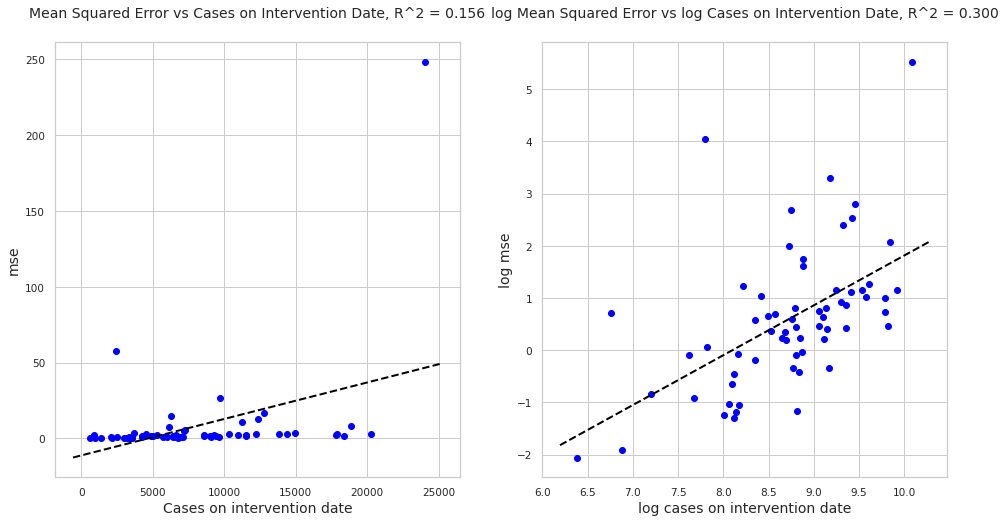

In [32]:
high_thresh = df.shape[0]
low_thresh = high_thresh-45
targets = counties_recommended #counties_recommended #masks_mandated
donors = counties_mandated.copy() #masks_recommended
singVals=3
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

print("Intervention date: ", testDF.index[0])

cases_list, error_list = [], []
cases_list_log, error_list_log = [], [] # I experimented with using matplotlib's builtin log scale, but I found this solution worked better

for state in targets:
    otherStates = df.columns[(df.iloc[low_thresh] < df[state].iloc[low_thresh]+.5*df[state].iloc[low_thresh])&(df.iloc[low_thresh] > df[state].iloc[low_thresh]-0.5*df[state].iloc[low_thresh])]
    otherStates = list(otherStates[otherStates.isin(donors)])
    if state in otherStates:
        otherStates.remove(state)
    rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
    rscModel.fit(trainDF)
    
    model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
    fit_error = mse(model_fit, df[state][:low_thresh])
    
    if not math.isnan(fit_error):
        cases = df[state][low_thresh]
        #cases = np.mean(df[state][low_thresh-7:low_thresh])
        
        cases_list.append(cases)
        error_list.append(fit_error)
        
        cases_list_log.append(np.log(cases))
        error_list_log.append(np.log(fit_error))
    
#TODO trend

    
fig_mse_cases, (ax_mse_cases, ax_mse_cases_log) = plt.subplots(1, 2, figsize=(16,8))
    
ax_mse_cases.scatter(cases_list, error_list, c='blue')
ax_mse_cases_log.scatter(cases_list_log, error_list_log, c='blue')

a, b, r, _, _ = scipy.stats.linregress(cases_list, error_list)
line_x = np.array(ax_mse_cases.get_xlim())
line_y = (a * line_x) + b
ax_mse_cases.plot(line_x, line_y, '--', c='black')


a_log, b_log, r_log, _, _ = scipy.stats.linregress(cases_list_log, error_list_log)
line_x_log = np.array(ax_mse_cases_log.get_xlim())
line_y_log = (a_log * line_x_log) + b_log
ax_mse_cases_log.plot(line_x_log, line_y_log, '--', c='black')

ax_mse_cases.set_title("Mean Squared Error vs Cases on Intervention Date, R^2 = %.3f" % r**2)
ax_mse_cases.set_xlabel("Cases on intervention date")
ax_mse_cases.set_ylabel("mse")

ax_mse_cases_log.set_title("log Mean Squared Error vs log Cases on Intervention Date, R^2 = %.3f" % r_log**2)
ax_mse_cases_log.set_xlabel("log cases on intervention date")
ax_mse_cases_log.set_ylabel("log mse")


plt.show()

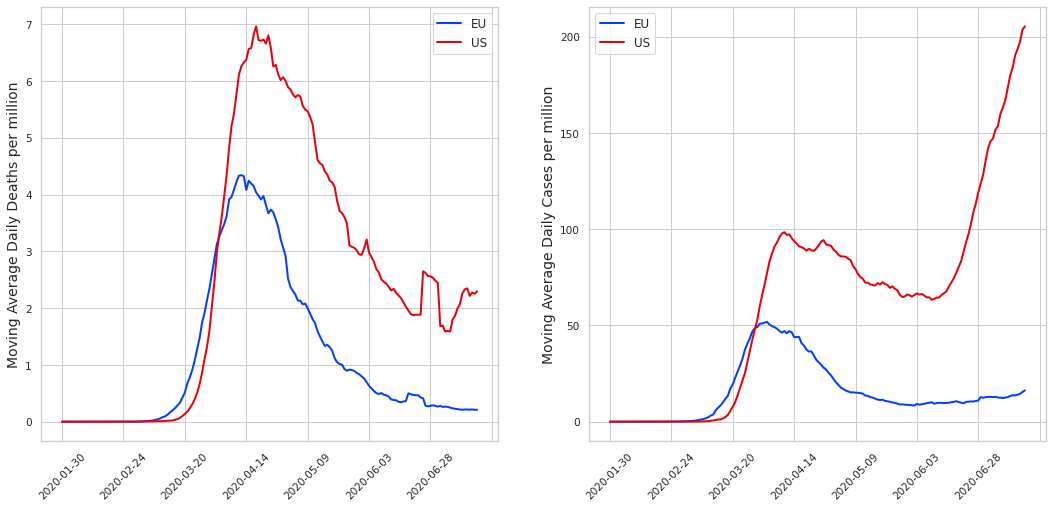

In [33]:
plt.rcParams['figure.figsize'] = (18, 8)

group_a = eu_countries
group_b = ['US']

group_a_label = "EU"
group_b_label = "US"

#group_a = masks_mandated
#group_b = masks_recommended

#group_a_label = 'Masks Mandated Everywhere'
#group_b_label = 'Masks Not Mandated Anywhere'

plt.subplot(1,2,1)
all_death_data_pop_daily[group_a].mean(axis=1).plot(label=group_a_label), all_death_data_pop_daily[group_b].mean(axis=1).plot(label=group_b_label), plt.legend(), plt.xticks(rotation=45), 
plt.ylabel('Moving Average Daily Deaths per million')
plt.subplot(1,2,2)
all_cases_data_pop_daily[group_a].mean(axis=1).plot(label=group_a_label), all_cases_data_pop_daily[group_b].mean(axis=1).plot(label=group_b_label), plt.legend(),
plt.xticks(rotation=45), plt.ylabel('Moving Average Daily Cases per million')
plt.show()

In [34]:
groups = [northeast, west, south, midwest]
group_labels = ["North East", "West", "South", "Midwest"]
southwest = south+west

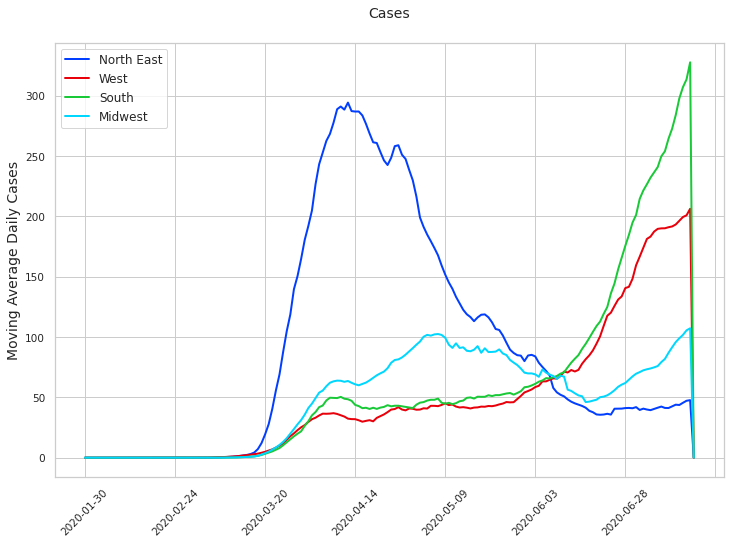

In [35]:
plt.rcParams['figure.figsize'] = (12, 8)
dfplot=all_data_cases_daily
i=0
for group in groups:
    (1000000*dfplot[group].sum(axis=1)/(all_population[all_population.index.isin(group)].value.sum())).plot(label=group_labels[i])
    plt.xticks(rotation=45), plt.ylabel('Moving Average Daily Cases'), plt.title('Cases'), plt.legend()
    i=i+1
plt.show()

### Cluster analysis

In [36]:
df = all_data_cases_daily[uscounties_cases_pop_adjusted.columns].loc['2020-05-01':]
counties_mandated = []
for state in ['New York']:
    counties_mandated = counties_mandated+list(uscounties.loc[uscounties.state == state].county_state.unique())

counties_recommended = []
for state in southwest:
    counties_recommended = counties_recommended + list(uscounties.loc[uscounties.state == state].county_state.unique())

df1 = df[df.columns[(df>10).any()]].copy()

counties_mandated = list(df1.columns[df1.columns.isin(counties_mandated)])
df1 = df[df.columns[(df>10).any()]].copy()

counties_recommended = list(df1.columns[df1.columns.isin(counties_recommended)])

In [37]:
df = all_cases_data_pop_daily[uscounties_cases_pop_adjusted.columns].loc['2020-05-01':]
len(df)

78

In [38]:
features = cluster_trend([df], 70, low_thresh, counties_recommended, singVals=2, donorPool = counties_mandated,
                            exclude=[], lambdas=[1,0.01], mRSC=False, error_thresh = 20, 
                            cluster_method = 'HDBSCAN', cluster_size = 5)

Acadia-Louisiana 32.57088993803989
Allen-Louisiana 29.07117471185895
Anderson-Texas 4346.462923073307
Bamberg-South Carolina 25.9730760777583
Bibb-Georgia 20.490734794169345
Brazos-Texas 21.295604536572075
Brewster-Texas 44.31292149392562
Broward-Florida 28.101478065661304
Bullock-Alabama 98.75995252239339
Cache-Utah 23.363687314299785
Calcasieu-Louisiana 32.59944605963397
Caldwell-Texas 30.890490333548524
Calhoun-Florida 25.61361468305936
Calhoun-South Carolina 22.337731159878746
Canyon-Idaho 21.23624559485337
Chambers-Texas 28.612824012124637
Charleston-South Carolina 38.69730911609127
Chattahoochee-Georgia 359.5722494806006
Coffee-Georgia 34.442691114049744
Collier-Florida 22.37602014387961
Colquitt-Georgia 33.714684637091224
Columbia-Florida 23.11019307514147
Cook-Georgia 23.247271858608897
Covington-Mississippi 29.134760386297472
Dallas-Alabama 34.323450145836475
Davidson-Tennessee 23.977565673581765
DeKalb-Alabama 22.602586866006504
DeSoto-Florida 33.69660270826324
Deaf Smith-Tex

In [145]:
features

{-1: Index(['Acadia-Louisiana', 'Adams-Colorado', 'Adams-Washington',
        'Alachua-Florida', 'Alamance-North Carolina', 'Albemarle-Virginia',
        'Alexandria city-Virginia', 'Allen-Louisiana', 'Anderson-Tennessee',
        'Angelina-Texas',
        ...
        'Wilson-North Carolina', 'Winston-Mississippi', 'Yakima-Washington',
        'Yavapai-Arizona', 'Yazoo-Mississippi', 'Yell-Arkansas',
        'Yellowstone-Montana', 'Yolo-California', 'Yuba-California',
        'Yuma-Arizona'],
       dtype='object', length=401),
 0: Index(['Accomack-Virginia', 'Anderson-Texas', 'Brewster-Texas', 'Cache-Utah',
        'Calcasieu-Louisiana', 'Caldwell-Texas', 'Canyon-Idaho',
        'Chambers-Texas', 'Charleston-South Carolina', 'Chattahoochee-Georgia',
        'Coffee-Georgia', 'Dare-North Carolina', 'Duval-Florida',
        'East Carroll-Louisiana', 'Echols-Georgia', 'Ector-Texas',
        'Escambia-Alabama', 'Escambia-Florida', 'Franklin-Louisiana',
        'Frio-Texas', 'Galveston-Texa

0


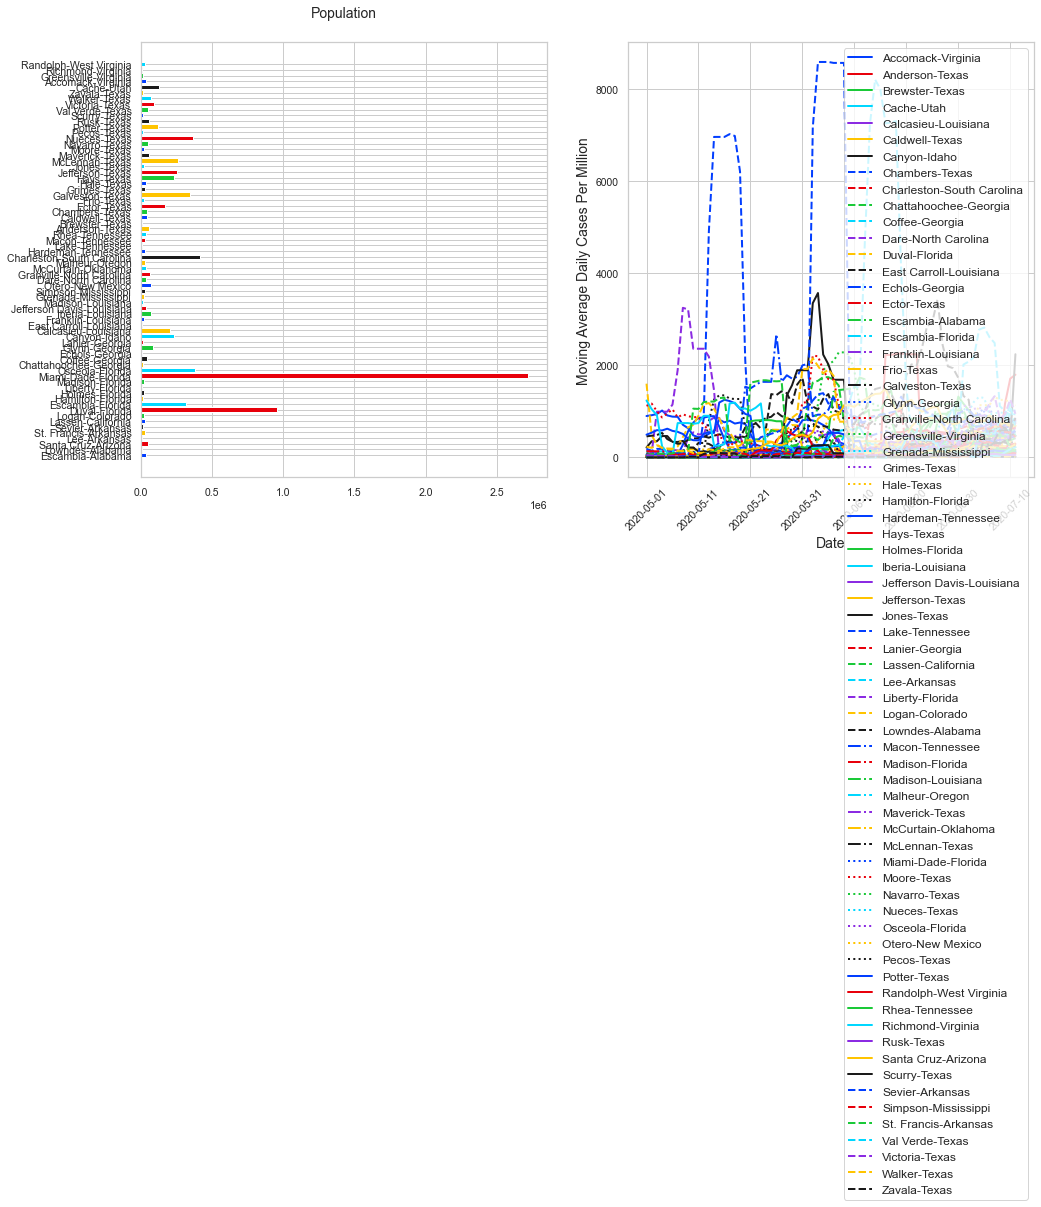

1


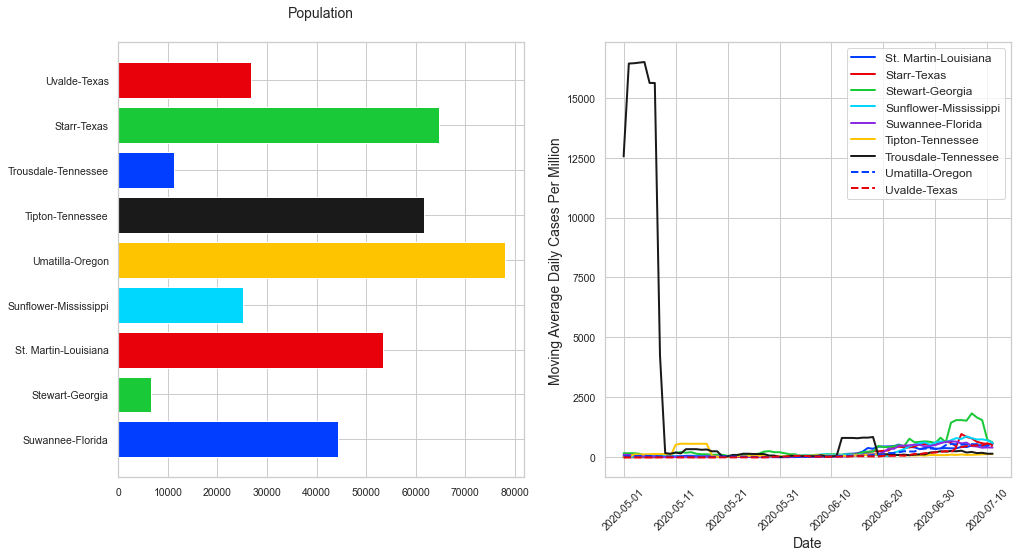

2


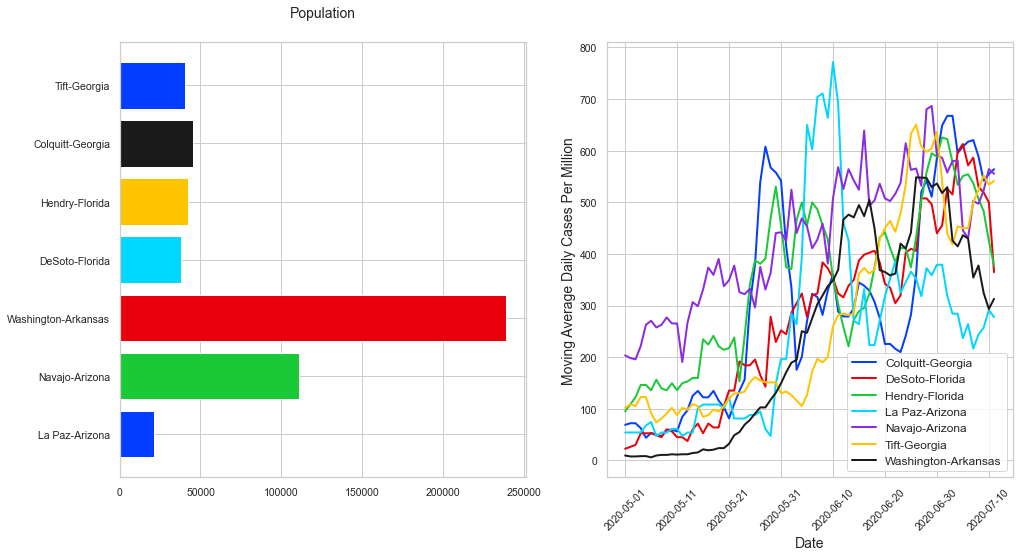

3


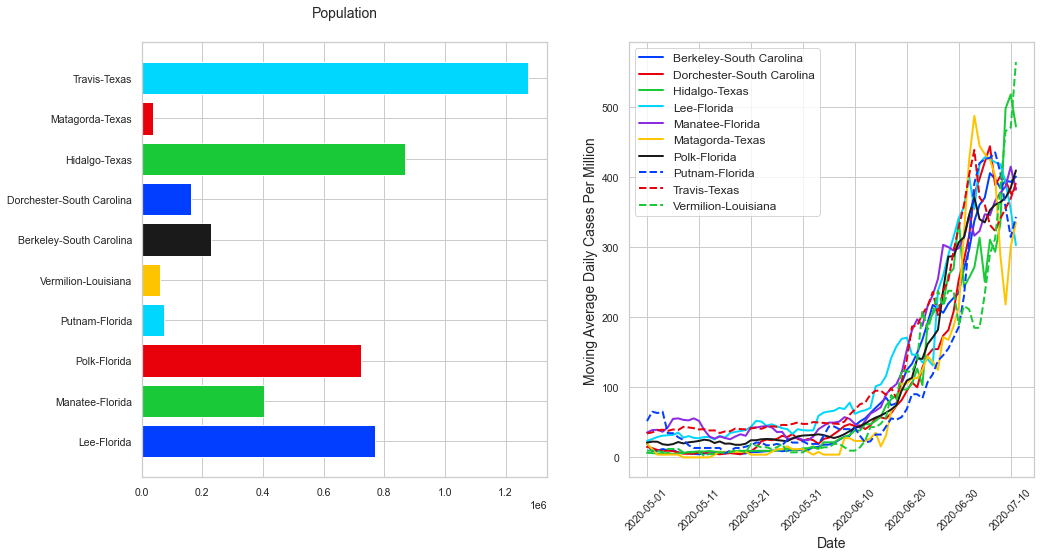

4


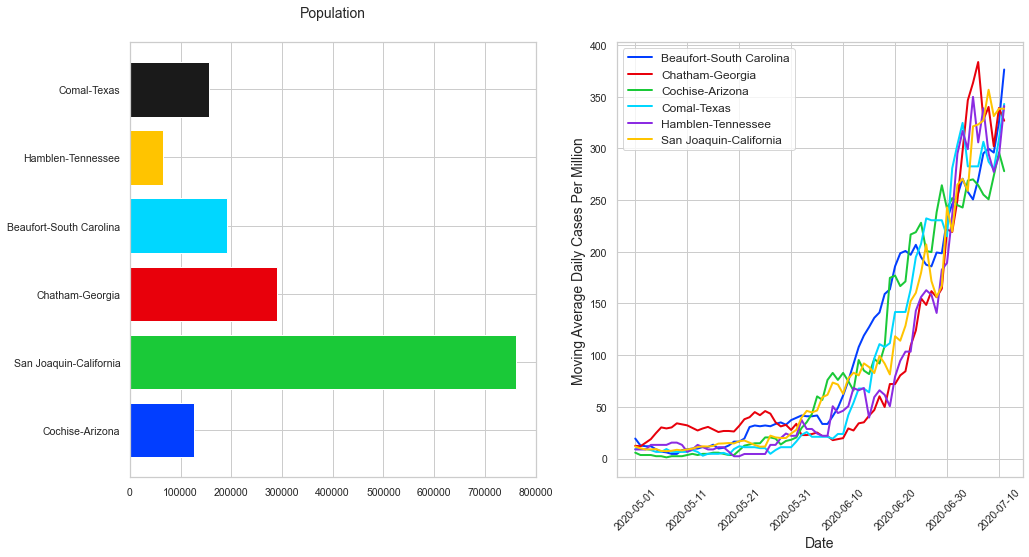

5


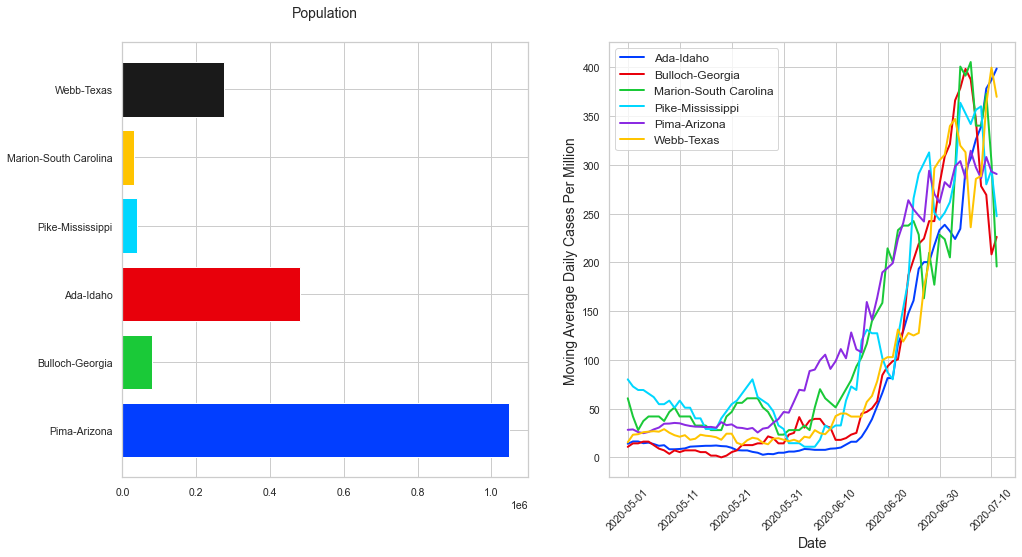

6


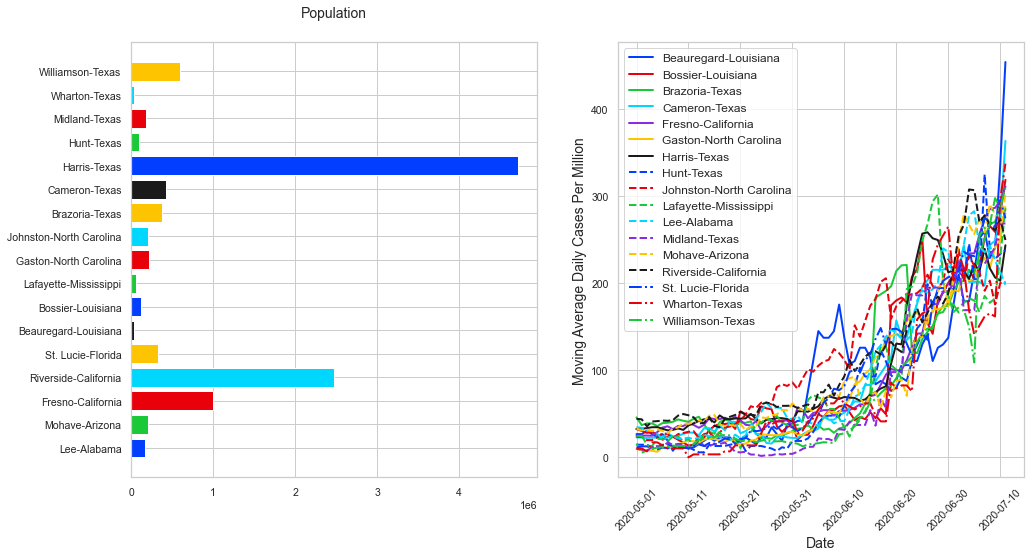

7


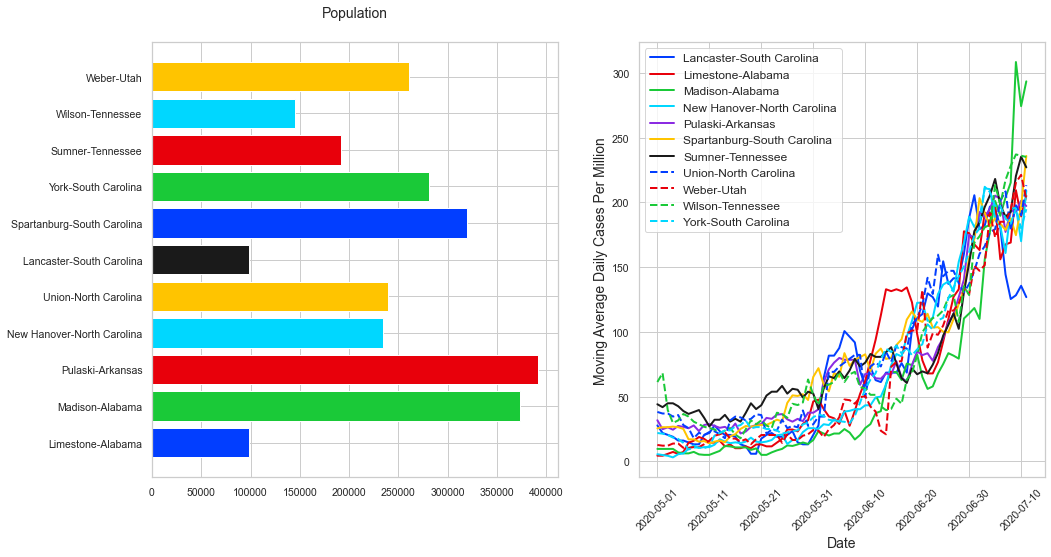

8


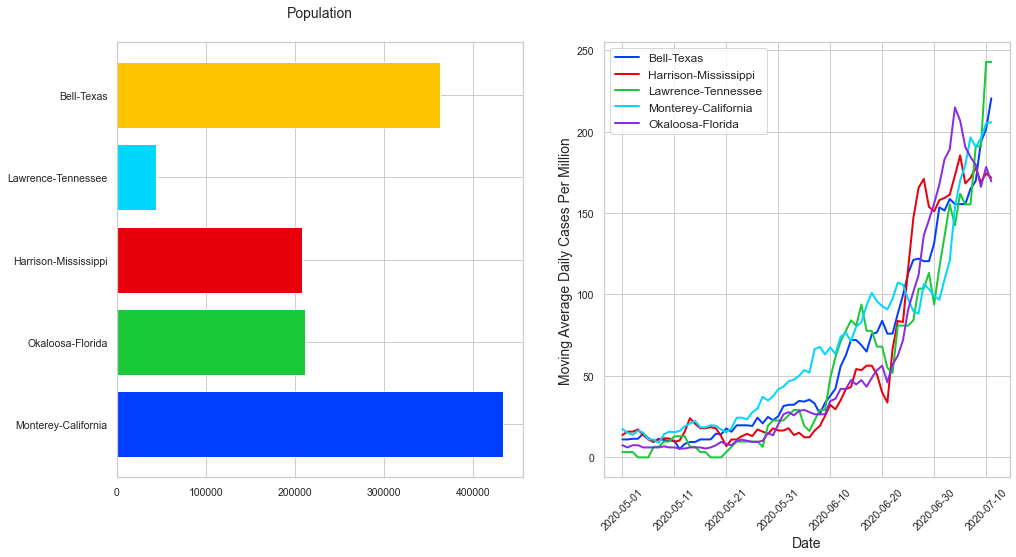

9


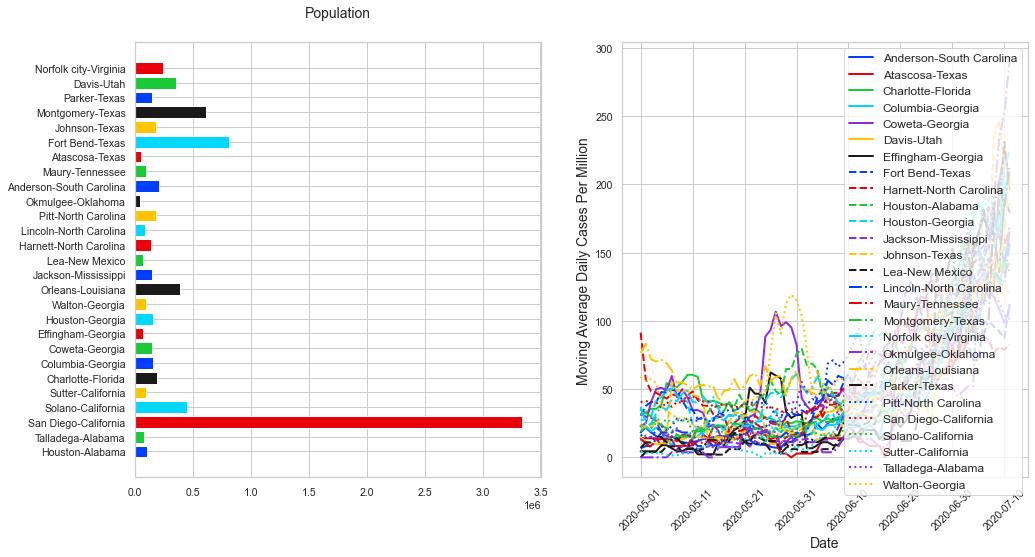

10


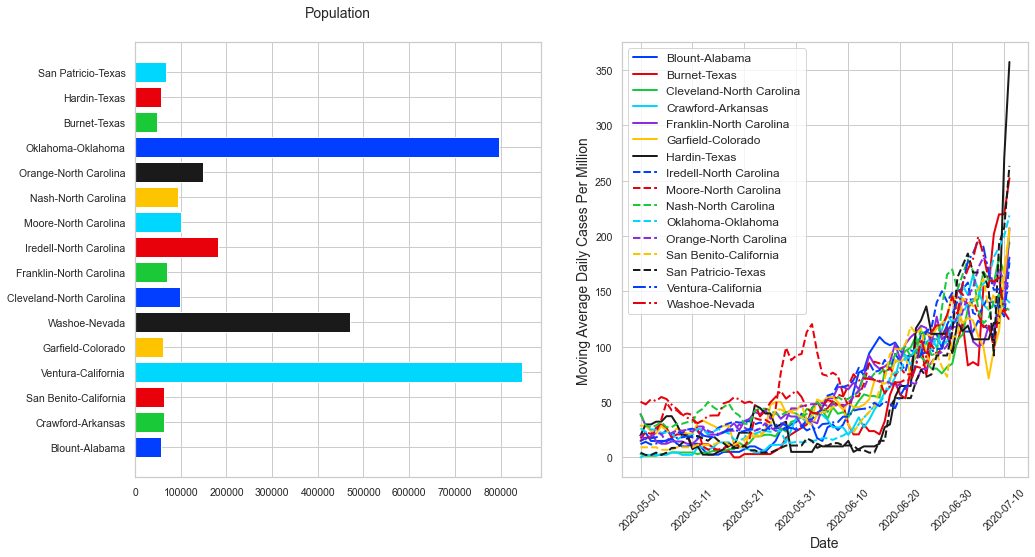

11


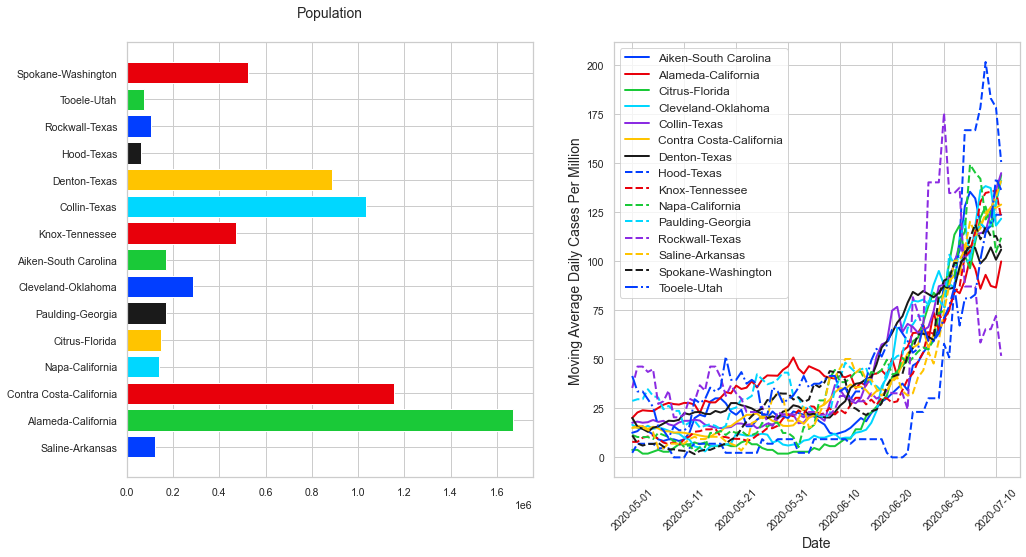

12


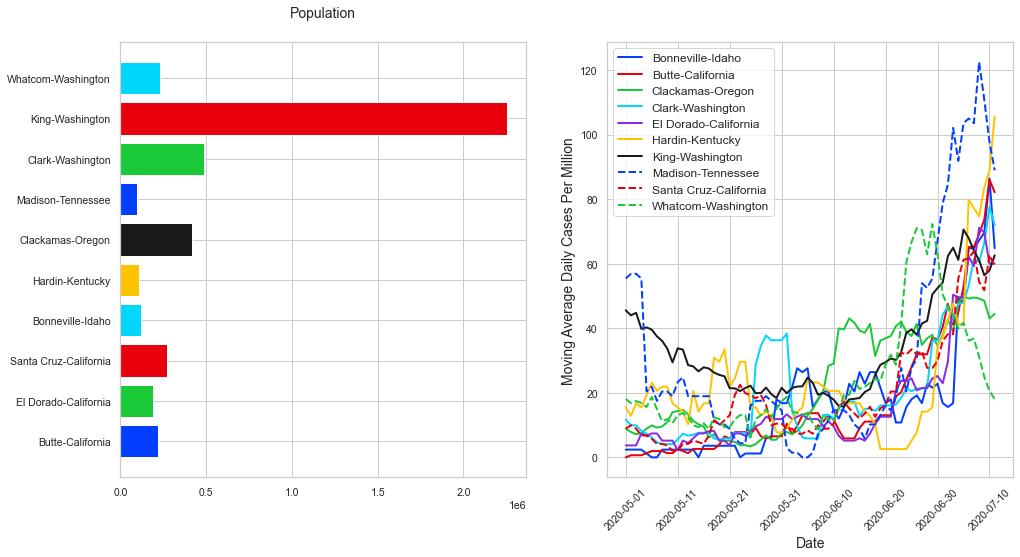

13


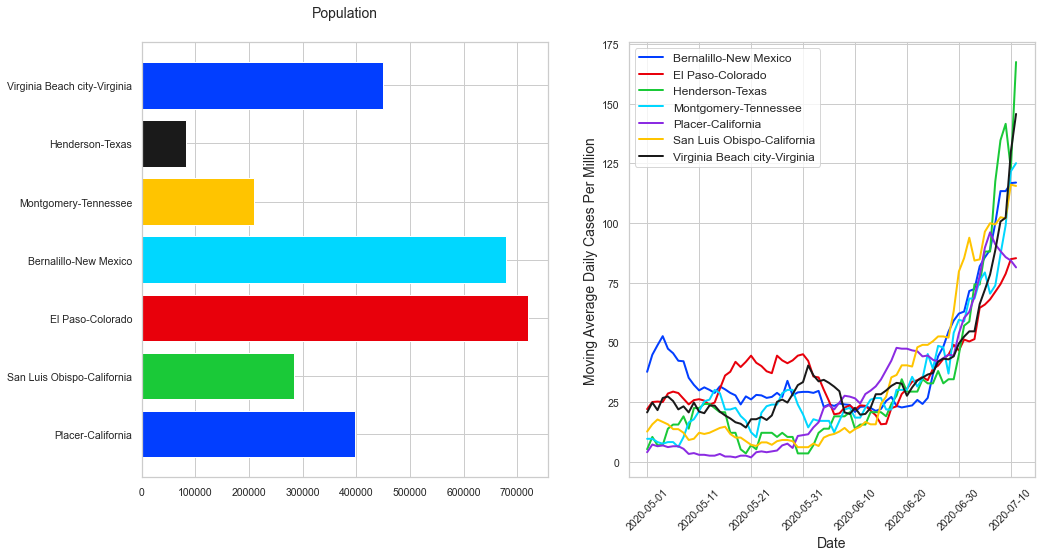

14


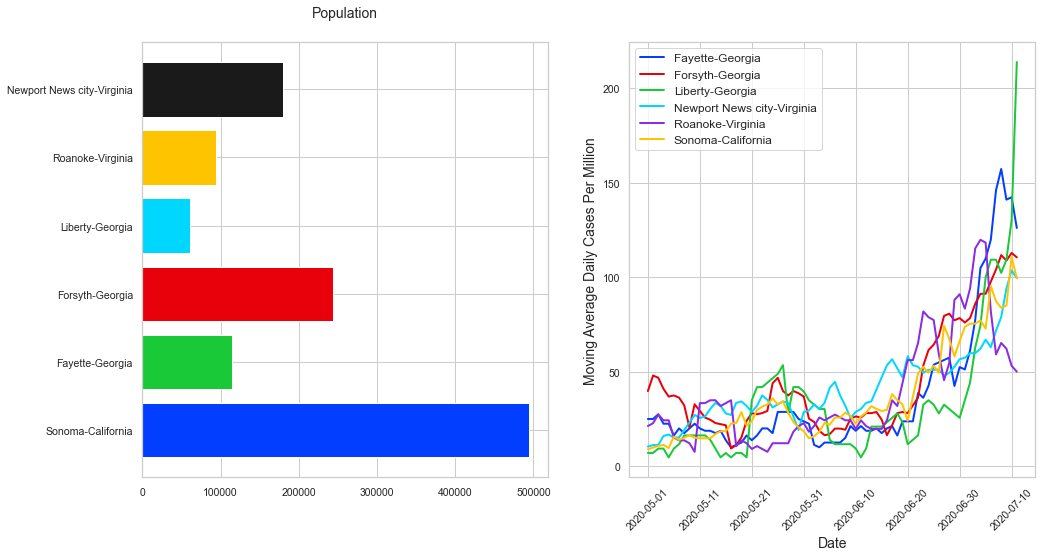

In [147]:
plt.rcParams['figure.figsize'] = (16, 8)
for i in range(0,len(features)-1):
    print(i)
    targets = list(features[i])
    ax = plt.subplot(1,2,2)
    df[targets].plot(ax = ax), plt.xticks(rotation=45), plt.ylabel('Moving Average Daily Cases Per Million'), plt.xlabel('Date')
    ax = plt.subplot(1,2,1)
    plt.barh(all_population[all_population.index.isin(targets)].index, all_population[all_population.index.isin(targets)].value, 
             color=list('bgrcyk')), plt.title('Population')
    #plt.savefig("../cluster_figures/raw-midwest-"+str(i)+".png")
    plt.show()


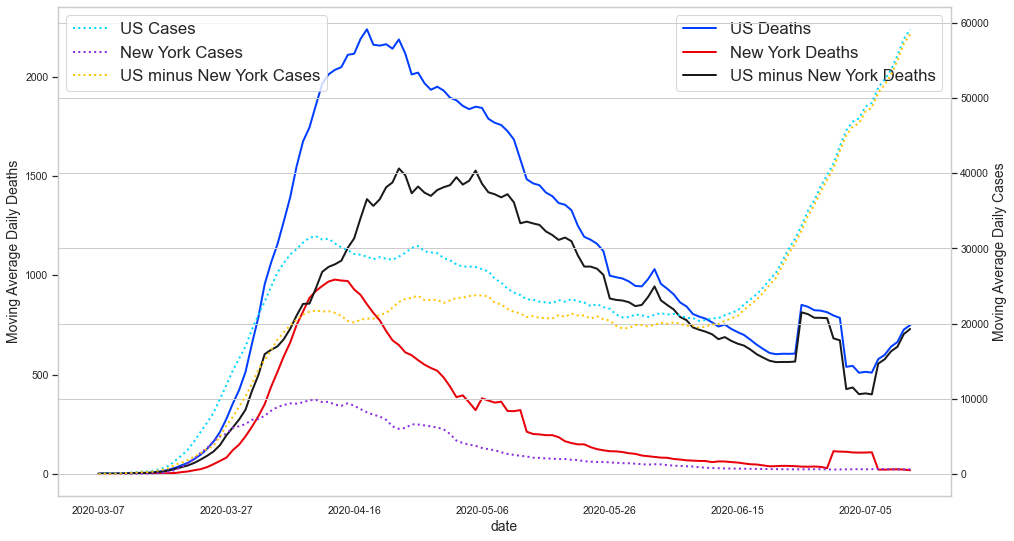

In [167]:
fig, ax = plt.subplots(1,1)

plt.rcParams['figure.figsize'] = (12.0, 9.0)

tri_state = all_data_daily['New York']#+all_data_daily['New Jersey']+all_data_daily['Connecticut']
tri_state_cases = all_data_cases_daily['New York']#+all_data_daily['New Jersey']+all_data_daily['Connecticut']

plt.rcParams.update({'font.size': 14})
us_minus_new_york = all_data_daily['US'] - tri_state
us_minus_new_york_cases = all_data_cases_daily['US'] - tri_state_cases

all_data_daily['US'].loc['2020-03-07':].plot(ax=ax, label='US Deaths'), tri_state.loc['2020-03-07':].plot(ax=ax, label="New York Deaths"), 
us_minus_new_york.loc['2020-03-07':].plot(ax=ax,color='k', label="US minus New York Deaths"), plt.ylabel('Moving Average Daily Deaths'), plt.legend(loc='upper right')

all_data_cases_daily['US'].loc['2020-03-07':].plot(ax=ax, label='US Cases', secondary_y=True,linestyle=":"), 
tri_state_cases.loc['2020-03-07':].plot(ax=ax, label="New York Cases", secondary_y=True,linestyle=":"),  
us_minus_new_york_cases.loc['2020-03-07':].plot(ax=ax, label="US minus New York Cases", secondary_y=True,linestyle=":"), plt.legend(loc='upper left'), plt.ylabel('Moving Average Daily Cases')
plt.show()
#deaths_intervention_adjusted_daily['Maryland'].plot(), deaths_intervention_adjusted_daily['Connecticut'].plot(), plt.legend(), plt.grid()